In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
import datetime 
import requests
import io
import re
from scipy import interpolate

# Data Processing

## Loading data

### Load social mobility data

In [2]:
# Load social mobility data directly from UMD website
url = "https://data.covid.umd.edu/data/County.csv"
s = requests.get(url).content
df_social_mobility_org = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
"""
    Pick useful columns in the social mobility dataset
    Criteria： exclude all columns that indicating ranks since they are relative data
               pick columns containing percentage or non-percentage values seperatly

"""
cols = [c for c in df_social_mobility_org.columns if c.lower()[-4:] != 'rank']
cols_1 = [c for c in cols if c.lower()[0] == '%']
cols_2 = [c for c in cols if c.lower()[0] != '%']
cols_1_new = ['% staying home', '% change in consumption', 
              '% people older than 60', '% Male', '% hospital bed utilization']

cols_new = ['CTFIPS', 'CTNAME', 'STFIPS', 
              'Social distancing index','Trips/person', 'Miles/person', 
              'date', 'Median income', 'Population density', 
              'Employment density', 'Hospital beds/1000 people', 'COVID exposure/1000 people', 
              'Unemployment rate', 'COVID death rate', 'Active cases/1000 people', 
              'Testing capacity', 'Tests done/1000 people']

cols_new.extend(cols_1_new)
cols_new

['CTFIPS',
 'CTNAME',
 'STFIPS',
 'Social distancing index',
 'Trips/person',
 'Miles/person',
 'date',
 'Median income',
 'Population density',
 'Employment density',
 'Hospital beds/1000 people',
 'COVID exposure/1000 people',
 'Unemployment rate',
 'COVID death rate',
 'Active cases/1000 people',
 'Testing capacity',
 'Tests done/1000 people',
 '% staying home',
 '% change in consumption',
 '% people older than 60',
 '% Male',
 '% hospital bed utilization']

In [4]:
# Partition the entire dataset based on the selected columns
df_social_mobility_org = df_social_mobility_org[cols_new]
df_social_mobility_org.head()

,CTFIPS,CTNAME,STFIPS,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,...,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization
0,1001,Autauga County,1,54,2.25,24.7,01/01/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,27,-22.5,19,48.68,47.1
1,1001,Autauga County,1,25,2.83,37.6,01/02/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,18,-14.3,19,48.68,47.1
2,1001,Autauga County,1,15,3.18,40.3,01/03/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,15,-0.4,19,48.68,47.1
3,1001,Autauga County,1,33,2.85,29.5,01/04/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,20,-2.3,19,48.68,47.1
4,1001,Autauga County,1,40,2.56,30.9,01/05/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,22,-9.7,19,48.68,47.1


In [5]:
# Also load the fips data from UMD website for consistancy modification in state name
url = "https://data.covid.umd.edu/fips-states.csv"
s = requests.get(url).content
df_state_fips = pd.read_csv(io.StringIO(s.decode('utf-8')))
cols = ['state_name', 'fips']
df_state_fips = df_state_fips[cols]

In [6]:
# Check the shape of the dataset
print(df_social_mobility_org.shape)
df_social_mobility_org.head()

(763506, 22)


,CTFIPS,CTNAME,STFIPS,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,...,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization
0,1001,Autauga County,1,54,2.25,24.7,01/01/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,27,-22.5,19,48.68,47.1
1,1001,Autauga County,1,25,2.83,37.6,01/02/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,18,-14.3,19,48.68,47.1
2,1001,Autauga County,1,15,3.18,40.3,01/03/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,15,-0.4,19,48.68,47.1
3,1001,Autauga County,1,33,2.85,29.5,01/04/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,20,-2.3,19,48.68,47.1
4,1001,Autauga County,1,40,2.56,30.9,01/05/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,22,-9.7,19,48.68,47.1


In [7]:
# Check the shape of the dataset
print(df_state_fips.shape)
df_state_fips.head()

(51, 2)


,state_name,fips
0,Alabama,1
1,Alaska,2
2,Arizona,4
3,Arkansas,5
4,California,6


In [8]:
#df_social_mobility_org['date'].unique()

### Load COVID19 data

In [9]:
"""
    Notice: this cell need to be run in the terminal
    Automatically update folked repo from JHU COVID19 dataset
"""
# ! cd '/Users/junyiguo/Documents/GitHub/COVID-19'
# ! git fetch upstream
# ! git checkout master
# ! git merge upstream/master

'\n    Notice: this cell need to be run in the terminal\n    Automatically update folked repo from JHU COVID19 dataset\n'

In [10]:
# Load COVID19 data from github repo
df_COVID19_org = pd.read_csv('/Users/junyiguo/Documents/GitHub/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df_COVID19_org.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,1281,1284,1296,1309,1345,1348,1354,1345,1349,1355
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,4166,4199,4230,4307,4402,4422,4445,4458,4495,4513
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,616,614,620,624,628,628,629,617,614,616
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,513,515,517,523,533,535,538,541,542,545
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,968,979,983,1004,1025,1034,1045,1036,1037,1049


In [11]:
# Check out the columns in COVID19 dataset
df_COVID19_org.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '8/26/20', '8/27/20', '8/28/20', '8/29/20', '8/30/20', '8/31/20',
       '9/1/20', '9/2/20', '9/3/20', '9/4/20'],
      dtype='object', length=238)

In [12]:
# Check the shape of the dataset
print(df_COVID19_org.shape)
df_COVID19_org.head()

(3340, 238)


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,1281,1284,1296,1309,1345,1348,1354,1345,1349,1355
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,4166,4199,4230,4307,4402,4422,4445,4458,4495,4513
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,616,614,620,624,628,628,629,617,614,616
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,513,515,517,523,533,535,538,541,542,545
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,968,979,983,1004,1025,1034,1045,1036,1037,1049


### Load hospital resources data

In [13]:
# Load the hospital resources data from local repo since the data is static
df_hospital_org = pd.read_csv('/Users/junyiguo/Documents/GitHub/Hospital_Resources/Definitive_Healthcare%3A_USA_Hospital_Beds.csv')
cols = ['COUNTY_NAME', 'STATE_NAME', 'NUM_LICENSED_BEDS', 'NUM_STAFFED_BEDS', 
        'NUM_ICU_BEDS', 'AVG_VENTILATOR_USAGE']
df_hospital_org = df_hospital_org[cols]
df_hospital_org.head()

,COUNTY_NAME,STATE_NAME,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
0,Maricopa,Arizona,62.0,62.0,0,0.0
1,Pima,Arizona,295.0,295.0,2,2.0
2,Fresno,California,54.0,54.0,2,2.0
3,New Haven,Connecticut,216.0,216.0,1,2.0
4,New Castle,Delaware,62.0,62.0,0,1.0


In [14]:
# loading original hospital data
# df_hospital_org = pd.read_csv('/Users/junyiguo/Documents/GitHub/Hospital_Resources/Definitive_Healthcare%3A_USA_Hospital_Beds.csv', usecols = ['COUNTY_NAME', 'STATE_NAME', 'NUM_LICENSED_BEDS', 'NUM_STAFFED_BEDS', 'AVG_VENTILATOR_USAGE'])
# df_social_mobility_org = pd.read_csv('/Users/junyiguo/Documents/summer_project/social_mobility_data/County.csv', usecols = ['CTNAME', 'STFIPS', 'date', 'Social distancing index', 'New cases/1000 people', 'Population density', '% people older than 60', 'COVID death rate'])
# df_COVID19_org = pd.read_csv('/Users/junyiguo/Documents/GitHub/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
# df_state_fips = pd.read_csv('//Users/junyiguo/Documents/summer_project/social_mobility_data/fips-states.csv', usecols = ['state_name', 'fips'])


In [15]:
# Check the shape of the dataset
print(df_hospital_org.shape)
df_hospital_org.head()

(6622, 6)


,COUNTY_NAME,STATE_NAME,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
0,Maricopa,Arizona,62.0,62.0,0,0.0
1,Pima,Arizona,295.0,295.0,2,2.0
2,Fresno,California,54.0,54.0,2,2.0
3,New Haven,Connecticut,216.0,216.0,1,2.0
4,New Castle,Delaware,62.0,62.0,0,1.0


## Preprocess Hospital resources data

In [16]:
# Drop null values
print(df_hospital_org.isnull().sum())
df_hospital = df_hospital_org.dropna()

COUNTY_NAME              28
STATE_NAME               28
NUM_LICENSED_BEDS       150
NUM_STAFFED_BEDS        238
NUM_ICU_BEDS              0
AVG_VENTILATOR_USAGE     71
dtype: int64


In [17]:
# Combining the state name with the county name and
# group the dataset by county
print(df_hospital.dtypes)
print(df_hospital.describe())

df_hospital['COUNTY'] = df_hospital['COUNTY_NAME'] + str(',') + df_hospital["STATE_NAME"]
df_hospital_group = df_hospital.groupby(by = 'COUNTY').agg('sum').reset_index()

df_hospital_group.drop(df_hospital_group.loc[(df_hospital_group['NUM_STAFFED_BEDS']/ df_hospital_group['NUM_LICENSED_BEDS'] <= 0.1) 
                                             & (df_hospital_group['NUM_STAFFED_BEDS'] <= 10)].index, inplace = True)
print(len(df_hospital_group))
df_hospital_group.head()

COUNTY_NAME              object
STATE_NAME               object
NUM_LICENSED_BEDS       float64
NUM_STAFFED_BEDS        float64
NUM_ICU_BEDS              int64
AVG_VENTILATOR_USAGE    float64
dtype: object
       NUM_LICENSED_BEDS  NUM_STAFFED_BEDS  NUM_ICU_BEDS  AVG_VENTILATOR_USAGE
count        6356.000000       6356.000000   6356.000000           6356.000000
mean          150.487256        128.924638     14.021554              3.650409
std           183.131072        160.582287     22.457457              5.517830
min             1.000000          1.000000      0.000000              0.000000
25%            26.000000         25.000000      3.000000              0.000000
50%            79.000000         66.000000      6.000000              2.000000
75%           200.000000        168.000000     16.000000              4.000000
max          2059.000000       2753.000000    310.000000             61.000000
2491


<ipython-input-17-5dfaeb9fe404>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hospital['COUNTY'] = df_hospital['COUNTY_NAME'] + str(',') + df_hospital["STATE_NAME"]


,COUNTY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
0,"Abbeville,South Carolina",25.0,25.0,6,2.0
1,"Acadia,Louisiana",170.0,144.0,7,3.0
2,"Accomack,Virginia",52.0,46.0,10,3.0
3,"Ada,Idaho",1311.0,1240.0,97,24.0
4,"Adair,Iowa",25.0,25.0,4,0.0


## Preprocess social mobility data

In [18]:
# Drop null values
print(df_social_mobility_org.isnull().sum())
df_social_mobility = df_social_mobility_org.dropna()

CTFIPS                        0
CTNAME                        0
STFIPS                        0
Social distancing index       0
Trips/person                  0
Miles/person                  0
date                          0
Median income                 0
Population density            0
Employment density            0
Hospital beds/1000 people     0
COVID exposure/1000 people    0
Unemployment rate             0
COVID death rate              0
Active cases/1000 people      0
Testing capacity              0
Tests done/1000 people        0
% staying home                0
% change in consumption       0
% people older than 60        0
% Male                        0
% hospital bed utilization    0
dtype: int64


In [19]:
# Modify county names to match names in the other dataset
df_social_mobility['CTNAME'] = df_social_mobility['CTNAME'].apply(lambda x: x.replace(str(' County'), ''))
df_social_mobility_merge = pd.merge(df_social_mobility, df_state_fips, left_on = 'STFIPS', right_on = 'fips')
df_social_mobility_merge['COUNTY'] = df_social_mobility_merge['CTNAME'] + str(',') + df_social_mobility_merge['state_name']
df_social_mobility_merge.drop(columns = ['CTFIPS', 'CTNAME', 'STFIPS', 'state_name', 'fips'], inplace = True)
df_social_mobility_merge.head()
#df_social_mobility_group = df_social_mobility_merge.groupby(by = 'date')

#print(df_social_mobility_group.size())
#df_social_mobility_current = df_social_mobility_group.get_group('06/22/2020')

# print(df_social_mobility_current.dtypes)
# print(df_social_mobility_current.describe())
# df_social_mobility_current.head()
#df_social_mobility_current['Population density'].plot.hist()

#df_social_mobility_current.loc[df_social_mobility_current['Population density'] == 0]
#len(df_social_mobility_group.get_group('01/01/2020')['COUNTY'].unique())

,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,Hospital beds/1000 people,COVID exposure/1000 people,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization,COUNTY
0,54,2.25,24.7,01/01/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,27,-22.5,19,48.68,47.1,"Autauga,Alabama"
1,25,2.83,37.6,01/02/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,18,-14.3,19,48.68,47.1,"Autauga,Alabama"
2,15,3.18,40.3,01/03/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,15,-0.4,19,48.68,47.1,"Autauga,Alabama"
3,33,2.85,29.5,01/04/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,20,-2.3,19,48.68,47.1,"Autauga,Alabama"
4,40,2.56,30.9,01/05/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,22,-9.7,19,48.68,47.1,"Autauga,Alabama"


In [20]:
print(df_social_mobility_merge.describe())

       Social distancing index   Trips/person   Miles/person  Median income  \
count            763506.000000  763506.000000  763506.000000  763506.000000   
mean                 27.324874       3.378396      44.509885   51580.443666   
std                  13.287284       0.607033      17.848849   13700.004574   
min                   0.000000       0.000000      -0.900000   20188.000000   
25%                  17.000000       3.000000      34.000000   42480.000000   
50%                  24.000000       3.380000      42.000000   49887.500000   
75%                  35.000000       3.740000      51.400000   57611.000000   
max                 100.000000      73.170000     299.800000  136268.000000   

       Population density  Employment density  Hospital beds/1000 people  \
count       763506.000000       763506.000000              763506.000000   
mean           224.436665          125.601846                   3.178877   
std           1270.265289         1307.283977               

In [21]:
# Drop data for county that have negative Miles/person data
county_dropped = df_social_mobility_merge['COUNTY'].loc[df_social_mobility_merge['Miles/person'] < 0].values[0]
df_social_mobility_merge.drop(index = df_social_mobility_merge.loc[df_social_mobility_merge['COUNTY'] == county_dropped].index, inplace = True)


In [22]:
print(df_social_mobility_merge.describe())

       Social distancing index   Trips/person   Miles/person  Median income  \
count            763263.000000  763263.000000  763263.000000  763263.000000   
mean                 27.319316       3.378505      44.513287   51582.903534   
std                  13.280993       0.606875      17.845650   13701.491459   
min                   0.000000       0.000000       0.000000   20188.000000   
25%                  17.000000       3.000000      34.000000   42480.000000   
50%                  24.000000       3.380000      42.000000   49888.000000   
75%                  35.000000       3.740000      51.500000   57611.000000   
max                 100.000000      73.170000     299.800000  136268.000000   

       Population density  Employment density  Hospital beds/1000 people  \
count       763263.000000       763263.000000              763263.000000   
mean           224.507800          125.641834                   3.178848   
std           1270.461223         1307.490139               

## Preprocess COVID19 data

In [23]:
# Drop null values
print(df_COVID19_org.isnull().sum())
df_COVID19 = df_COVID19_org.dropna()
print(df_COVID19.shape)

UID         0
iso2        0
iso3        0
code3       0
FIPS       10
           ..
8/31/20     0
9/1/20      0
9/2/20      0
9/3/20      0
9/4/20      0
Length: 238, dtype: int64
(3324, 238)


In [24]:
#df_COVID19.columns.to_series()

In [25]:
# Generate demographic information for finding nearby counties later on
df_COVID19_demo = df_COVID19[['Admin2', 'Province_State', 'Lat', 'Long_']]
df_COVID19_demo['COUNTY'] = df_COVID19_demo['Admin2'] + str(',') + df_COVID19_demo['Province_State']
df_COVID19_demo.drop(columns = ['Admin2', 'Province_State'], inplace = True)
df_COVID19_demo.head()

<ipython-input-25-810a7af68d0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_COVID19_demo['COUNTY'] = df_COVID19_demo['Admin2'] + str(',') + df_COVID19_demo['Province_State']
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Lat,Long_,COUNTY
0,32.539527,-86.644082,"Autauga,Alabama"
1,30.727750,-87.722071,"Baldwin,Alabama"
2,31.868263,-85.387129,"Barbour,Alabama"
3,32.996421,-87.125115,"Bibb,Alabama"
4,33.982109,-86.567906,"Blount,Alabama"


#### Find common time section for both COVID19 and social mobility dataset

In [26]:
# Get the date range for social mobility data as well as COVID19 data
# for matching the datasets later on
date_COVID19 = df_COVID19.columns.values
date_SMD = df_social_mobility['date'].unique()

In [27]:
# print(date_COVID19)
# print(date_SMD)

In [28]:
# Set the start date of the useful data to be the earliest common date in both datasets
# ang the end date to be the last common date in both datasets

def get_start_and_end(dates):
    """
        This method find the earlist date and the last date in the data
    """
    date_list = []
    for date in dates:
        try:
            #print(date)
            if re.match('^[0-9]{1}[/][0-9]{2}/[0-9]{2}$', date):
                date  = date + '20'
            date_t = datetime.datetime.strptime(date,"%m/%d/%Y")
            date_list.append(date_t)
        except ValueError:
            if re.match('^[0-9]{1}[/][0-9]{2}/[0-9]{2}$', date):
                print('Date not converted to datetime properly!')
                print(date)
                return
            continue
    start = min(date_list)
    end = max(date_list)
#     start_date = datetime.datetime(2020, 3, 1)
#     end_date = datetime.datetime(2020, 6, 26)
#     print(min(date_list))
#     print(max(date_list))
    return start, end

In [29]:
# Find the start date and the end date for both dataset and decide the date range for the useful data
start_COVID19, end_COVID19 = get_start_and_end(date_COVID19)
start_SMD, end_SMD = get_start_and_end(date_SMD)
start_date = max(start_COVID19, start_SMD)
end_date = min(end_COVID19, end_SMD)
print(start_date, end_date)

2020-01-22 00:00:00 2020-08-30 00:00:00


In [30]:
# import re
# if re.match('^[0-9]{1}[/][0-9]{2}/[0-9]{2}$', '9/29/20'):
#     print('True values')

In [31]:
# daily_part
# this function partition data segments between the input start date and end date 
# specifically targetting COVID19 dataframe
# input: df: target dataframe, start: start date, end: end date
# return: the partitioned dataframe
def daily_part(df, start, end):
    start_idx = df.columns.get_loc(start)
    end_idx = df.columns.get_loc(end)
    
    df_daily = df.iloc[:, start_idx: end_idx + 1]
    return df_daily

In [32]:
# Partition cumulative positive test number between 
start = start_date.strftime("%m/%d/%Y")[1:-2]
end = end_date.strftime("%m/%d/%Y")[1:-2]
print(start, end)
df_COVID19_daily = daily_part(df_COVID19, start, end)
df_COVID19_daily.head()

1/22/20 8/30/20


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20
0,0,0,0,0,0,0,0,0,0,0,...,1255,1264,1266,1286,1286,1281,1284,1296,1309,1345
1,0,0,0,0,0,0,0,0,0,0,...,3997,4037,4069,4083,4100,4166,4199,4230,4307,4402
2,0,0,0,0,0,0,0,0,0,0,...,622,626,629,633,628,616,614,620,624,628
3,0,0,0,0,0,0,0,0,0,0,...,501,503,510,510,511,513,515,517,523,533
4,0,0,0,0,0,0,0,0,0,0,...,930,931,934,946,967,968,979,983,1004,1025


### Apply non-decreasing filter to the original COVID19 data

In [33]:
"""
    Since the original COVID19 data contains decreasing cumulative cases number due to 
    inevitable reporting error,here we apply naive filter to help create non-decreasing daily reported cumulative cases
"""
def interp_filter(data, county, index):
    """
        This is method uses interpolation to alter the input data to be a
        non-decreasing array
        Procedure: 1) if the current data value is smaller or equal to the next data value, do not change the value
                   2) if the current data value is larger than the next data value, find the next point that is equal or 
                   larger than the current data value, and do interpolation between those data point
                       * if the current data is larger than all data values after, set all data values afterward to 
                        be the same as the current data value
    """
    filtered_data = np.array([])
    i = 0
    while i < len(data):
        # print(i)
        if i == len(data) - 1:
            filtered_data = np.append(filtered_data, data[i])
            break
        
        if data[i] > data[i + 1]:
            #print(county, index)
            j = i
            window = 0
            while data[i] > data[j + 1]:
                if j + 1 == len(data) - 1:
                    y_new = np.array([data[i]] * (j - i + 2))
                    filtered_data = np.append(filtered_data, y_new)
                    return filtered_data.astype(int)
                
                window += 1
                j += 1
            x = np.array([0, window + 1])
            y = np.array([data[i], data[i + window + 1]])
            f = interpolate.interp1d(x, y)
            
            x_new = np.arange(0, window + 1)
            y_new = f(x_new)
            filtered_data = np.append(filtered_data, y_new)
            i += (window + 1)
        else:
            filtered_data = np.append(filtered_data, data[i])
            i += 1
            
    return filtered_data.astype(int)
            
            

In [34]:
# Check and fit the interpolation filter on all counties' data
for i in range(len(df_COVID19_daily)):
    df_COVID19_daily.iloc[i] = interp_filter(df_COVID19_daily.iloc[i].values, df_COVID19_demo.iloc[i], i)

In [35]:
df_COVID19_daily.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20
0,0,0,0,0,0,0,0,0,0,0,...,1255,1264,1266,1286,1286,1289,1292,1296,1309,1345
1,0,0,0,0,0,0,0,0,0,0,...,3997,4037,4069,4083,4100,4166,4199,4230,4307,4402
2,0,0,0,0,0,0,0,0,0,0,...,622,626,629,633,633,633,633,633,633,633
3,0,0,0,0,0,0,0,0,0,0,...,501,503,510,510,511,513,515,517,523,533
4,0,0,0,0,0,0,0,0,0,0,...,930,931,934,946,967,968,979,983,1004,1025


### Conbining the demographic imformation with the filtered numerical data for COVID19 dataset

In [36]:
# Combining the demograohic information with the numerical data for COVID19 dataset
df_COVID19 = pd.concat([df_COVID19_demo, df_COVID19_daily], axis = 1)
df_COVID19.head()

,Lat,Long_,COUNTY,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20
0,32.539527,-86.644082,"Autauga,Alabama",0,0,0,0,0,0,0,...,1255,1264,1266,1286,1286,1289,1292,1296,1309,1345
1,30.727750,-87.722071,"Baldwin,Alabama",0,0,0,0,0,0,0,...,3997,4037,4069,4083,4100,4166,4199,4230,4307,4402
2,31.868263,-85.387129,"Barbour,Alabama",0,0,0,0,0,0,0,...,622,626,629,633,633,633,633,633,633,633
3,32.996421,-87.125115,"Bibb,Alabama",0,0,0,0,0,0,0,...,501,503,510,510,511,513,515,517,523,533
4,33.982109,-86.567906,"Blount,Alabama",0,0,0,0,0,0,0,...,930,931,934,946,967,968,979,983,1004,1025


In [37]:
# Drop unassigned cases and out of state cases for each state since those data are not useful
df_COVID19.drop(index = df_COVID19[df_COVID19['COUNTY'].str.contains('Unassigned')].index, inplace = True)
df_COVID19.drop(index = df_COVID19[df_COVID19['COUNTY'].str.contains('Out of')].index, inplace = True)

In [38]:
df_COVID19

,Lat,Long_,COUNTY,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20
0,32.539527,-86.644082,"Autauga,Alabama",0,0,0,0,0,0,0,...,1255,1264,1266,1286,1286,1289,1292,1296,1309,1345
1,30.727750,-87.722071,"Baldwin,Alabama",0,0,0,0,0,0,0,...,3997,4037,4069,4083,4100,4166,4199,4230,4307,4402
2,31.868263,-85.387129,"Barbour,Alabama",0,0,0,0,0,0,0,...,622,626,629,633,633,633,633,633,633,633
3,32.996421,-87.125115,"Bibb,Alabama",0,0,0,0,0,0,0,...,501,503,510,510,511,513,515,517,523,533
4,33.982109,-86.567906,"Blount,Alabama",0,0,0,0,0,0,0,...,930,931,934,946,967,968,979,983,1004,1025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,41.659439,-108.882788,"Sweetwater,Wyoming",0,0,0,0,0,0,0,...,288,290,290,290,295,295,295,296,296,301
3335,43.935225,-110.589080,"Teton,Wyoming",0,0,0,0,0,0,0,...,399,401,409,409,412,417,417,424,425,429
3336,41.287818,-110.547578,"Uinta,Wyoming",0,0,0,0,0,0,0,...,283,283,283,283,283,289,289,292,292,295
3338,43.904516,-107.680187,"Washakie,Wyoming",0,0,0,0,0,0,0,...,106,107,108,108,108,108,108,108,108,108


## Get 5 nearby county

In [39]:
df_COVID19.head()

,Lat,Long_,COUNTY,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20
0,32.539527,-86.644082,"Autauga,Alabama",0,0,0,0,0,0,0,...,1255,1264,1266,1286,1286,1289,1292,1296,1309,1345
1,30.727750,-87.722071,"Baldwin,Alabama",0,0,0,0,0,0,0,...,3997,4037,4069,4083,4100,4166,4199,4230,4307,4402
2,31.868263,-85.387129,"Barbour,Alabama",0,0,0,0,0,0,0,...,622,626,629,633,633,633,633,633,633,633
3,32.996421,-87.125115,"Bibb,Alabama",0,0,0,0,0,0,0,...,501,503,510,510,511,513,515,517,523,533
4,33.982109,-86.567906,"Blount,Alabama",0,0,0,0,0,0,0,...,930,931,934,946,967,968,979,983,1004,1025


In [104]:
# Create dataframe with only demograohic imformation
df_county = df_COVID19[['COUNTY', 'Lat', 'Long_']]

In [105]:
# np.radians(df_county['Lat'].values)

In [106]:
def dist_from_coordinates(lat_list, lon_list, lat_cur, lon_cur):
    """
        dist_from_coordinates
        Get the distance between two coordinate using haversine formula
        input: lat_list: list of latitude
               lon_list: list of longitude
               lat_cur: current point latitude
               lon_cur: current point longitude
        return: array of distance
    """
    # Earth radius in km
    R = 6371

    #conversion to radians
    d_lat = np.radians(lat_list-lat_cur)
    d_lon = np.radians(lon_list-lon_cur)

    r_lat_list = np.radians(lat_list)
    r_lat_cur = np.radians(lat_cur)

    #haversine formula
    a = np.sin(d_lat/2.) **2 + np.cos(r_lat_list) * np.cos(r_lat_cur) * np.sin(d_lon/2.)**2

    haversine = 2 * R * np.arcsin(np.sqrt(a))

    return haversine

In [107]:
def get_NearbyCounty(df, row):
    """
        get_NearbyCounty
        This function find the nearby county by rank for the current row using the haversine formula 
        and the coordinate for each county
        input: df: the geographic dataframe; row: row index
        return: list countaining 5 nearby counties' name
    """
    # df['Distance'] = np.sqrt((df['Lat'] - row['Lat'])**2 + (df['Long_'] - row['Long_'])**2)
    df['Distance'] = dist_from_coordinates(df['Lat'], df['Long_'], row['Lat'], row['Long_'])
    df.sort_values(by = ['Distance'], inplace = True)
    # county_array = np.array(df['COUNTY'].iloc[1:6].values)
    county_array = np.array(df['COUNTY'].iloc[1:6].values)
    # print(county_array)
    return county_array

In [108]:
# Generate nearby county
# type(df_county.apply(lambda x: get_NearbyCounty(df_county.copy(), x), axis = 1))
df_county['NEARBY_COUNTY_total'] = df_county.apply(lambda x: get_NearbyCounty(df_county.copy(), x), axis = 1)
# df = pd.DataFrame(df_county.NEARBY_COUNTY_total.tolist(), index= df_county.index)
# for i in range(len(df[0])):
#     if len(df[0].iloc[i]) != 5:
#         print(i)
#df_county[['1st_NEARBY_COUNTY', '2nd_NEARBY_COUNTY', '3rd_NEARBY_COUNTY', '4th_NEARBY_COUNTY', '5th_NEARBY_COUNTY']] = pd.DataFrame(df_county['NEARBY_COUNTY_total'].to_list(), index= df_county.index)
# df
# df_county['NEARBY_COUNTY_total'][0]
df_county.head()

<ipython-input-108-9f85c51e7941>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_county['NEARBY_COUNTY_total'] = df_county.apply(lambda x: get_NearbyCounty(df_county.copy(), x), axis = 1)


,COUNTY,Lat,Long_,NEARBY_COUNTY_total
0,"Autauga,Alabama",32.539527,-86.644082,"[Chilton,Alabama, Lowndes,Alabama, Elmore,Alab..."
1,"Baldwin,Alabama",30.727750,-87.722071,"[Escambia,Florida, Mobile,Alabama, Santa Rosa,..."
2,"Barbour,Alabama",31.868263,-85.387129,"[Quitman,Georgia, Bullock,Alabama, Henry,Alaba..."
3,"Bibb,Alabama",32.996421,-87.125115,"[Chilton,Alabama, Perry,Alabama, Tuscaloosa,Al..."
4,"Blount,Alabama",33.982109,-86.567906,"[Cullman,Alabama, St. Clair,Alabama, Etowah,Al..."


In [109]:
df_county.shape

(3220, 4)

In [110]:
# Drop latitude abd longitude columns
# df_county.drop(columns = ['Lat', 'Long_', 'NEARBY_COUNTY_total'], inplace = True)
df_county.drop(columns = ['Lat', 'Long_'], inplace = True)
df_county.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,COUNTY,NEARBY_COUNTY_total
0,"Autauga,Alabama","[Chilton,Alabama, Lowndes,Alabama, Elmore,Alab..."
1,"Baldwin,Alabama","[Escambia,Florida, Mobile,Alabama, Santa Rosa,..."
2,"Barbour,Alabama","[Quitman,Georgia, Bullock,Alabama, Henry,Alaba..."
3,"Bibb,Alabama","[Chilton,Alabama, Perry,Alabama, Tuscaloosa,Al..."
4,"Blount,Alabama","[Cullman,Alabama, St. Clair,Alabama, Etowah,Al..."


In [111]:
# Convert the dataframe to dictionary
dict_nearby = df_county.set_index('COUNTY')['NEARBY_COUNTY_total'].to_dict()
# dict_nearby_1 = df_county.set_index('COUNTY')['1st_NEARBY_COUNTY'].to_dict()
# dict_nearby_2 = df_county.set_index('COUNTY')['2nd_NEARBY_COUNTY'].to_dict()
# dict_nearby_3 = df_county.set_index('COUNTY')['3rd_NEARBY_COUNTY'].to_dict()
# dict_nearby_4 = df_county.set_index('COUNTY')['4th_NEARBY_COUNTY'].to_dict()
# dict_nearby_5 = df_county.set_index('COUNTY')['5th_NEARBY_COUNTY'].to_dict()
#len(dict_NearbyCounty['Autauga,Alabama'][0])

In [112]:
dict_nearby['San Diego,California']

array(['Riverside,California', 'Orange,California', 'Imperial,California',
       'Los Angeles,California', 'San Bernardino,California'],
      dtype=object)

In [48]:
#df_sub.iloc[0]['COUNTY'] in df_sub["NEARBY_COUNTY"].iloc[3][0]

## Altering structure for COVID19 dataset

In [49]:
# Create date array
date_array = np.array(df_COVID19_daily.columns)
datetime_array = [datetime.datetime.strptime(date + '20',"%m/%d/%Y") for date in date_array]
datetime_list = [datetime.strftime("%m/%d/%Y") for datetime in datetime_array]
datetime_list = datetime_list[1:]

In [50]:
# Drop unnecessary columns and reset index
df_COVID19_tempo = df_COVID19.drop(columns = ['Lat', 'Long_'])
df_COVID19_tempo.set_index('COUNTY', inplace = True)

In [51]:
# Since the original data is cumulative cases count,
# here we change each columns to be the daily increase count
df_copy = df_COVID19_tempo.copy()
for i in range(len(df_COVID19_tempo.columns) - 1):
    df_COVID19_tempo.iloc[:, i + 1] = df_copy.iloc[:, i + 1] - df_copy.iloc[:, i]
df_COVID19_tempo = df_COVID19_tempo.iloc[:, 1:]

In [52]:
# Convert the data type to be integer for the entire COVID19 numerical data
df_COVID19_tempo = df_COVID19_tempo.astype(int)
df_COVID19_tempo.head()

,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,...,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20
COUNTY,,,,,,,,,,,,,,,,,,,,,
"Autauga,Alabama",0,0,0,0,0,0,0,0,0,0,...,7,9,2,20,0,3,3,4,13,36
"Baldwin,Alabama",0,0,0,0,0,0,0,0,0,0,...,40,40,32,14,17,66,33,31,77,95
"Barbour,Alabama",0,0,0,0,0,0,0,0,0,0,...,3,4,3,4,0,0,0,0,0,0
"Bibb,Alabama",0,0,0,0,0,0,0,0,0,0,...,7,2,7,0,1,2,2,2,6,10
"Blount,Alabama",0,0,0,0,0,0,0,0,0,0,...,18,1,3,12,21,1,11,4,21,21


In [53]:
#print(i for i in range(len(df_COVID19_tempo['1/23/20'][df_COVID19_tempo['1/23/20'] < 0].index)))

In [54]:
# Double check to make sure no county has negative daily increase data
decrease_list = list(set([df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index[i] 
                          for col in df_COVID19_tempo.columns for i in range(len(df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index))]))
print(decrease_list)

[]


In [55]:
#[(df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index[i], df_COVID19_tempo.columns.get_loc(col)) for col in df_COVID19_tempo.columns for i in range(len(df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index))]
#len(set([df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index[i] for col in df_COVID19_tempo.columns for i in range(len(df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index))]))

"""
Only include California Data for testing
Delete after testing
"""

CA_decrease_county = []
for county in decrease_list:
    if 'California' in county:
        CA_decrease_county.append(county)
        
len(CA_decrease_county)

0

In [56]:
"""
Only include California Data for testing
Delete after testing
"""

df_COVID19_tempo = df_COVID19_tempo.reset_index()
df_COVID19_tempo = df_COVID19_tempo.loc[df_COVID19_tempo['COUNTY'].str.contains('California')]
df_COVID19_tempo = df_COVID19_tempo.reset_index()
index_drop = [i for i in df_COVID19_tempo.index.array if df_COVID19_tempo.iloc[i]['COUNTY'] in CA_decrease_county]
df_COVID19_tempo = df_COVID19_tempo.drop(index = index_drop)
df_COVID19_tempo.set_index('COUNTY', inplace = True)

In [57]:
df_COVID19_tempo.drop(columns = ['index'], inplace = True)

In [58]:
"""
    Since we want each row to be the daily increase count for a single county in a single date,
    we stack the numeric data matrix into a 1-d array, and copy the county list and date array
    in according order
    We check the length for each array to make sure they are the same and can be merged into one dataframe later
"""
stack_array = df_COVID19_tempo.stack().values.tolist()
print(len(stack_array))

county_array = np.array([])
county_array = np.repeat(df_COVID19_tempo.index, len(datetime_list)).tolist()
print(len(county_array))

cum_date_array = datetime_list * len(df_COVID19_tempo.index)
print(len(cum_date_array))

12818
12818
12818


In [59]:
# Merge the three arrays created earlier into one entire dataframe
df_COVID19_final = pd.DataFrame({'COUNTY': county_array, 'DATE': cum_date_array, 'DAILY_INCREASE': stack_array})
df_COVID19_final['COUNTY_AND_DATE'] = df_COVID19_final['COUNTY'] + str(',') + df_COVID19_final['DATE']
df_COVID19_final.head()

,COUNTY,DATE,DAILY_INCREASE,COUNTY_AND_DATE
0,"Alameda,California",01/23/2020,0,"Alameda,California,01/23/2020"
1,"Alameda,California",01/24/2020,0,"Alameda,California,01/24/2020"
2,"Alameda,California",01/25/2020,0,"Alameda,California,01/25/2020"
3,"Alameda,California",01/26/2020,0,"Alameda,California,01/26/2020"
4,"Alameda,California",01/27/2020,0,"Alameda,California,01/27/2020"


In [60]:
#df_COVID19_final[(df_COVID19_final['COUNTY'] == 'San Diego,California') & (df_COVID19_final['DATE'] == '06/17/2020')]

### Partition data after 10 days of the local outbreak for each counties

In [61]:
"""
    Since the local outbreak starts differently in different counties, 
    in order to avoid tones of zero values in the daily increase count,
    we only keep the data 10 days after each county present confirmed cases
"""
df_COVID19_group = df_COVID19_final.groupby(by = 'COUNTY')
counties = df_COVID19_group.groups.keys()
df_COVID19_part = pd.DataFrame()
for county in counties:
    df_temp = df_COVID19_group.get_group(county)
    df_temp = df_temp.reset_index(drop = True)
    index = df_temp.loc[df_temp['DAILY_INCREASE'] != 0].index[0]
    df_temp = df_temp.iloc[index + 10: ]
    df_COVID19_part = pd.concat([df_COVID19_part, df_temp], ignore_index=True)

df_COVID19_final = df_COVID19_part


## Minor change in Social Mobility Dataset

In [62]:
df_social_mobility_merge.head()

,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,Hospital beds/1000 people,COVID exposure/1000 people,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization,COUNTY
0,54,2.25,24.7,01/01/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,27,-22.5,19,48.68,47.1,"Autauga,Alabama"
1,25,2.83,37.6,01/02/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,18,-14.3,19,48.68,47.1,"Autauga,Alabama"
2,15,3.18,40.3,01/03/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,15,-0.4,19,48.68,47.1,"Autauga,Alabama"
3,33,2.85,29.5,01/04/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,20,-2.3,19,48.68,47.1,"Autauga,Alabama"
4,40,2.56,30.9,01/05/2020,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,22,-9.7,19,48.68,47.1,"Autauga,Alabama"


In [63]:
#df_social_mobility_merge[(df_social_mobility_merge['COUNTY'] == 'San Diego,California') & (df_social_mobility_merge['date'] == '06/17/2020')]

In [64]:
#len(df_social_mobility_merge)

In [65]:
# Change the date date in social mobility dataset to be datetime object and get the corresponding start date
# and end date from the COVID19 dataset
df_social_mobility_merge['date'] = [datetime.datetime.strptime(date,"%m/%d/%Y") for date in df_social_mobility_merge['date']]
start_date = datetime.datetime.strptime(datetime_list[0],"%m/%d/%Y")
end_date = datetime.datetime.strptime(datetime_list[-1],"%m/%d/%Y")


In [66]:
df_social_mobility_part = df_social_mobility_merge[(df_social_mobility_merge['date'] >= start_date) 
                                                   & (df_social_mobility_merge['date'] <= end_date)]

In [67]:
df_social_mobility_part.head()

,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,Hospital beds/1000 people,COVID exposure/1000 people,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization,COUNTY
22,13,3.22,42.8,2020-01-23,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,14,-3.9,19,48.68,47.1,"Autauga,Alabama"
23,9,3.53,40.4,2020-01-24,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,11,10.5,19,48.68,47.1,"Autauga,Alabama"
24,26,3.08,33.7,2020-01-25,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,18,7.8,19,48.68,47.1,"Autauga,Alabama"
25,40,2.59,28.2,2020-01-26,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,20,-8.5,19,48.68,47.1,"Autauga,Alabama"
26,14,3.21,36.4,2020-01-27,58786,91,19,3.79,0.0,2.7,0.0,0.0,0.0,0.0,14,-3.1,19,48.68,47.1,"Autauga,Alabama"


In [68]:
# Create the reference column containing 
df_social_mobility_part['date'] = [datetime.strftime("%m/%d/%Y") for datetime in df_social_mobility_part['date']]
df_social_mobility_part['COUNTY_AND_DATE'] = df_social_mobility_part['COUNTY'] + str(',') + df_social_mobility_part['date']


<ipython-input-68-7aab9dac9dd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_social_mobility_part['date'] = [datetime.strftime("%m/%d/%Y") for datetime in df_social_mobility_part['date']]
<ipython-input-68-7aab9dac9dd5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_social_mobility_part['COUNTY_AND_DATE'] = df_social_mobility_part['COUNTY'] + str(',') + df_social_mobility_part['date']


In [69]:
df_social_mobility_part.head()

,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,Hospital beds/1000 people,COVID exposure/1000 people,Unemployment rate,...,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization,COUNTY,COUNTY_AND_DATE
22,13,3.22,42.8,01/23/2020,58786,91,19,3.79,0.0,2.7,...,0.0,0.0,0.0,14,-3.9,19,48.68,47.1,"Autauga,Alabama","Autauga,Alabama,01/23/2020"
23,9,3.53,40.4,01/24/2020,58786,91,19,3.79,0.0,2.7,...,0.0,0.0,0.0,11,10.5,19,48.68,47.1,"Autauga,Alabama","Autauga,Alabama,01/24/2020"
24,26,3.08,33.7,01/25/2020,58786,91,19,3.79,0.0,2.7,...,0.0,0.0,0.0,18,7.8,19,48.68,47.1,"Autauga,Alabama","Autauga,Alabama,01/25/2020"
25,40,2.59,28.2,01/26/2020,58786,91,19,3.79,0.0,2.7,...,0.0,0.0,0.0,20,-8.5,19,48.68,47.1,"Autauga,Alabama","Autauga,Alabama,01/26/2020"
26,14,3.21,36.4,01/27/2020,58786,91,19,3.79,0.0,2.7,...,0.0,0.0,0.0,14,-3.1,19,48.68,47.1,"Autauga,Alabama","Autauga,Alabama,01/27/2020"


In [70]:
df_social_mobility_part.shape

(694161, 21)

## Combining social mobility datasets and COVID19 dataset

In [71]:
# Merge the two dataset
df_mobility_COVID19 = pd.merge(df_COVID19_final, df_social_mobility_part, on = ['COUNTY_AND_DATE'])
df_mobility_COVID19_new = df_mobility_COVID19.drop(columns = ['date', 'COUNTY_y'])
df_mobility_COVID19_new = df_mobility_COVID19_new.rename(columns = {'COUNTY_x': 'COUNTY', 
                                                                    'DAILY_INCREASE': 'Daily increase'})
df_mobility_COVID19_new.head()

,COUNTY,DATE,Daily increase,COUNTY_AND_DATE,Social distancing index,Trips/person,Miles/person,Median income,Population density,Employment density,...,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization
0,"Alameda,California",03/13/2020,2,"Alameda,California,03/13/2020",19,3.49,35.0,92574,2002,1155,...,5.3,0.06,0.01,18.1,0.03,22,3.1,19,49.11,54.062406
1,"Alameda,California",03/14/2020,4,"Alameda,California,03/14/2020",48,2.82,28.3,92574,2002,1155,...,5.3,0.07,0.01,21.6,0.03,31,-9.3,19,49.11,54.079393
2,"Alameda,California",03/15/2020,0,"Alameda,California,03/15/2020",59,2.46,26.3,92574,2002,1155,...,5.8,0.08,0.01,24.2,0.03,36,-20.6,19,49.11,54.096944
3,"Alameda,California",03/16/2020,7,"Alameda,California,03/16/2020",33,3.18,30.9,92574,2002,1155,...,5.8,0.08,0.01,4.0,0.21,27,-6.8,19,49.11,54.114330
4,"Alameda,California",03/17/2020,9,"Alameda,California,03/17/2020",61,2.46,23.8,92574,2002,1155,...,5.8,0.13,0.02,5.7,0.21,40,-27.4,19,49.11,54.142102


In [72]:
# Switch the column for future convenience
col_list = list(df_mobility_COVID19_new.columns)
col_list[2], col_list[3] = col_list[3], col_list[2]
df_mobility_COVID19_new = df_mobility_COVID19_new[col_list]
df_mobility_COVID19_new.head()

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Social distancing index,Trips/person,Miles/person,Median income,Population density,Employment density,...,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization
0,"Alameda,California",03/13/2020,"Alameda,California,03/13/2020",2,19,3.49,35.0,92574,2002,1155,...,5.3,0.06,0.01,18.1,0.03,22,3.1,19,49.11,54.062406
1,"Alameda,California",03/14/2020,"Alameda,California,03/14/2020",4,48,2.82,28.3,92574,2002,1155,...,5.3,0.07,0.01,21.6,0.03,31,-9.3,19,49.11,54.079393
2,"Alameda,California",03/15/2020,"Alameda,California,03/15/2020",0,59,2.46,26.3,92574,2002,1155,...,5.8,0.08,0.01,24.2,0.03,36,-20.6,19,49.11,54.096944
3,"Alameda,California",03/16/2020,"Alameda,California,03/16/2020",7,33,3.18,30.9,92574,2002,1155,...,5.8,0.08,0.01,4.0,0.21,27,-6.8,19,49.11,54.114330
4,"Alameda,California",03/17/2020,"Alameda,California,03/17/2020",9,61,2.46,23.8,92574,2002,1155,...,5.8,0.13,0.02,5.7,0.21,40,-27.4,19,49.11,54.142102


In [73]:
df_mobility_COVID19_new.columns

Index(['COUNTY', 'DATE', 'COUNTY_AND_DATE', 'Daily increase',
       'Social distancing index', 'Trips/person', 'Miles/person',
       'Median income', 'Population density', 'Employment density',
       'Hospital beds/1000 people', 'COVID exposure/1000 people',
       'Unemployment rate', 'COVID death rate', 'Active cases/1000 people',
       'Testing capacity', 'Tests done/1000 people', '% staying home',
       '% change in consumption', '% people older than 60', '% Male',
       '% hospital bed utilization'],
      dtype='object')

## Generating daily increase, social distancing index and death rate for each county during the past 1-10 days

In [74]:
def get_previous(df, col_name, new_col_name, period):
    counties = df['COUNTY'].unique()
    data = np.array([])
    for county in counties:
        county_data = df[col_name][df['COUNTY'] == county]
        county_new_data = county_data[: -period]
        fill_in = np.array([None] * period)
        county_final_data = np.append(fill_in, county_new_data)
        data = np.append(data, county_final_data)
    df[new_col_name] = data
    return df

In [75]:
def get_after(df, col_name, new_col_name, period):
    counties = df['COUNTY'].unique()
    data = np.array([])
    for county in counties:
        county_data = df[col_name][df['COUNTY'] == county]
        county_new_data = county_data[period:]
        fill_in = np.array([None] * period)
        county_final_data = np.append(county_new_data, fill_in)
        data = np.append(data, county_final_data)
    df[new_col_name] = data
    return df

### Generating new features on the entire dataset

In [76]:
feature_total = list(df_mobility_COVID19_new.columns)
feature_use = [f for f in feature_total if f not in ['COUNTY', 'DATE', 'COUNTY_AND_DATE',]]
feature_10 = ['Daily increase','Social distancing index', 'Trips/person', 
              'COVID exposure/1000 people', 'Unemployment rate', 
              'COVID death rate', 'Active cases/1000 people', 
              'Tests done/1000 people']
feature_1 = [f for f in feature_use if f not in feature_10]
feature_dropped = [f for f in feature_use if f != 'Daily increase']

In [77]:
period_date = 10
for f in feature_10:
    for period in range(1, period_date + 1):
        print('Generating feature: ' + f)
        print('Generating feature for past day: ' + str(period))
        new_col_name = f + '_' + str(period) + 'd'
        df_mobility_COVID19_new = get_previous(df_mobility_COVID19_new.copy(), f, new_col_name, period)

df_mobility_COVID19_new.iloc[:20]

Generating feature: Daily increase
Generating feature for past day: 1
Generating feature: Daily increase
Generating feature for past day: 2
Generating feature: Daily increase
Generating feature for past day: 3
Generating feature: Daily increase
Generating feature for past day: 4
Generating feature: Daily increase
Generating feature for past day: 5
Generating feature: Daily increase
Generating feature for past day: 6
Generating feature: Daily increase
Generating feature for past day: 7
Generating feature: Daily increase
Generating feature for past day: 8
Generating feature: Daily increase
Generating feature for past day: 9
Generating feature: Daily increase
Generating feature for past day: 10
Generating feature: Social distancing index
Generating feature for past day: 1
Generating feature: Social distancing index
Generating feature for past day: 2
Generating feature: Social distancing index
Generating feature for past day: 3
Generating feature: Social distancing index
Generating feature

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Social distancing index,Trips/person,Miles/person,Median income,Population density,Employment density,...,Tests done/1000 people_1d,Tests done/1000 people_2d,Tests done/1000 people_3d,Tests done/1000 people_4d,Tests done/1000 people_5d,Tests done/1000 people_6d,Tests done/1000 people_7d,Tests done/1000 people_8d,Tests done/1000 people_9d,Tests done/1000 people_10d
0,"Alameda,California",03/13/2020,"Alameda,California,03/13/2020",2,19,3.49,35.0,92574,2002,1155,...,None,None,None,None,None,None,None,None,None,None
1,"Alameda,California",03/14/2020,"Alameda,California,03/14/2020",4,48,2.82,28.3,92574,2002,1155,...,0.03,None,None,None,None,None,None,None,None,None
2,"Alameda,California",03/15/2020,"Alameda,California,03/15/2020",0,59,2.46,26.3,92574,2002,1155,...,0.03,0.03,None,None,None,None,None,None,None,None
3,"Alameda,California",03/16/2020,"Alameda,California,03/16/2020",7,33,3.18,30.9,92574,2002,1155,...,0.03,0.03,0.03,None,None,None,None,None,None,None
4,"Alameda,California",03/17/2020,"Alameda,California,03/17/2020",9,61,2.46,23.8,92574,2002,1155,...,0.21,0.03,0.03,0.03,None,None,None,None,None,None
5,"Alameda,California",03/18/2020,"Alameda,California,03/18/2020",3,60,2.46,23.8,92574,2002,1155,...,0.21,0.21,0.03,0.03,0.03,None,None,None,None,None
6,"Alameda,California",03/19/2020,"Alameda,California,03/19/2020",8,59,2.52,23.3,92574,2002,1155,...,0.22,0.21,0.21,0.03,0.03,0.03,None,None,None,None
7,"Alameda,California",03/20/2020,"Alameda,California,03/20/2020",10,59,2.55,23.7,92574,2002,1155,...,0.25,0.22,0.21,0.21,0.03,0.03,0.03,None,None,None
8,"Alameda,California",03/21/2020,"Alameda,California,03/21/2020",20,70,2.22,20.7,92574,2002,1155,...,0.29,0.25,0.22,0.21,0.21,0.03,0.03,0.03,None,None
9,"Alameda,California",03/22/2020,"Alameda,California,03/22/2020",3,76,2.02,18.0,92574,2002,1155,...,0.32,0.29,0.25,0.22,0.21,0.21,0.03,0.03,0.03,None


In [78]:
# period_date = 10
# for period in range(1, period_date + 1):
#     print('Generating feature for past day: ' + str(period))
#     new_col_name = 'Social distancing index_' + str(period) + 'd'
#     df_mobility_COVID19_new = get_previous(df_mobility_COVID19_new.copy(), 'Social distancing index', new_col_name, period)

# print(df_mobility_COVID19_new.shape)
# df_mobility_COVID19_new.iloc[:20]

In [79]:
# all(df_mobility_COVID19_new.groupby('COUNTY')['% people older than 60'].value_counts() == 118)

In [80]:
# all(df_mobility_COVID19_new.groupby('COUNTY')['Population density'].value_counts() == 118)

In [81]:
period_date = 1
for f in feature_1:
    for period in range(1, period_date + 1):
        print('Generating feature: ' + f)
        print('Generating feature for past day: ' + str(period))
        new_col_name = f + '_' + str(period) + 'd'
        df_mobility_COVID19_new = get_previous(df_mobility_COVID19_new.copy(), f, new_col_name, period)

df_mobility_COVID19_new.iloc[:20]

Generating feature: Miles/person
Generating feature for past day: 1
Generating feature: Median income
Generating feature for past day: 1
Generating feature: Population density
Generating feature for past day: 1
Generating feature: Employment density
Generating feature for past day: 1
Generating feature: Hospital beds/1000 people
Generating feature for past day: 1
Generating feature: Testing capacity
Generating feature for past day: 1
Generating feature: % staying home
Generating feature for past day: 1
Generating feature: % change in consumption
Generating feature for past day: 1
Generating feature: % people older than 60
Generating feature for past day: 1
Generating feature: % Male
Generating feature for past day: 1
Generating feature: % hospital bed utilization
Generating feature for past day: 1


,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Social distancing index,Trips/person,Miles/person,Median income,Population density,Employment density,...,Median income_1d,Population density_1d,Employment density_1d,Hospital beds/1000 people_1d,Testing capacity_1d,% staying home_1d,% change in consumption_1d,% people older than 60_1d,% Male_1d,% hospital bed utilization_1d
0,"Alameda,California",03/13/2020,"Alameda,California,03/13/2020",2,19,3.49,35.0,92574,2002,1155,...,None,None,None,None,None,None,None,None,None,None
1,"Alameda,California",03/14/2020,"Alameda,California,03/14/2020",4,48,2.82,28.3,92574,2002,1155,...,92574,2002,1155,2.05,18.1,22,3.1,19,49.11,54.0624
2,"Alameda,California",03/15/2020,"Alameda,California,03/15/2020",0,59,2.46,26.3,92574,2002,1155,...,92574,2002,1155,2.05,21.6,31,-9.3,19,49.11,54.0794
3,"Alameda,California",03/16/2020,"Alameda,California,03/16/2020",7,33,3.18,30.9,92574,2002,1155,...,92574,2002,1155,2.05,24.2,36,-20.6,19,49.11,54.0969
4,"Alameda,California",03/17/2020,"Alameda,California,03/17/2020",9,61,2.46,23.8,92574,2002,1155,...,92574,2002,1155,2.05,4,27,-6.8,19,49.11,54.1143
5,"Alameda,California",03/18/2020,"Alameda,California,03/18/2020",3,60,2.46,23.8,92574,2002,1155,...,92574,2002,1155,2.05,5.7,40,-27.4,19,49.11,54.1421
6,"Alameda,California",03/19/2020,"Alameda,California,03/19/2020",8,59,2.52,23.3,92574,2002,1155,...,92574,2002,1155,2.05,7.1,40,-27.4,19,49.11,54.177
7,"Alameda,California",03/20/2020,"Alameda,California,03/20/2020",10,59,2.55,23.7,92574,2002,1155,...,92574,2002,1155,2.05,9.5,38,-24.9,19,49.11,54.2282
8,"Alameda,California",03/21/2020,"Alameda,California,03/21/2020",20,70,2.22,20.7,92574,2002,1155,...,92574,2002,1155,2.05,9.3,38,-23.5,19,49.11,54.2846
9,"Alameda,California",03/22/2020,"Alameda,California,03/22/2020",3,76,2.02,18.0,92574,2002,1155,...,92574,2002,1155,2.05,10.2,44,-30.2,19,49.11,54.3438


In [164]:
df_mobility_COVID19_dropped = df_mobility_COVID19_new.dropna()
df_mobility_COVID19_dropped.head()

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Social distancing index,Trips/person,Miles/person,Median income,Population density,Employment density,...,Median income_1d,Population density_1d,Employment density_1d,Hospital beds/1000 people_1d,Testing capacity_1d,% staying home_1d,% change in consumption_1d,% people older than 60_1d,% Male_1d,% hospital bed utilization_1d
10,"Alameda,California",03/23/2020,"Alameda,California,03/23/2020",47,65,2.33,20.0,92574,2002,1155,...,92574,2002,1155,2.05,12,48,-35.5,19,49.11,54.4084
11,"Alameda,California",03/24/2020,"Alameda,California,03/24/2020",17,67,2.27,18.3,92574,2002,1155,...,92574,2002,1155,2.05,12.1,42,-30.6,19,49.11,54.4751
12,"Alameda,California",03/25/2020,"Alameda,California,03/25/2020",0,65,2.36,18.5,92574,2002,1155,...,92574,2002,1155,2.05,13.5,43,-33.4,19,49.11,54.5442
13,"Alameda,California",03/26/2020,"Alameda,California,03/26/2020",43,65,2.37,19.0,92574,2002,1155,...,92574,2002,1155,2.05,12.9,42,-30.2,19,49.11,54.6179
14,"Alameda,California",03/27/2020,"Alameda,California,03/27/2020",42,61,2.49,20.9,92574,2002,1155,...,92574,2002,1155,2.05,14.7,42,-30.2,19,49.11,54.699


In [165]:
feature_dropped

['Social distancing index',
 'Trips/person',
 'Miles/person',
 'Median income',
 'Population density',
 'Employment density',
 'Hospital beds/1000 people',
 'COVID exposure/1000 people',
 'Unemployment rate',
 'COVID death rate',
 'Active cases/1000 people',
 'Testing capacity',
 'Tests done/1000 people',
 '% staying home',
 '% change in consumption',
 '% people older than 60',
 '% Male',
 '% hospital bed utilization']

In [166]:
df_mobility_COVID19_dropped = df_mobility_COVID19_dropped.drop(columns = feature_dropped)
print(df_mobility_COVID19_dropped.shape)
df_mobility_COVID19_dropped.head()

(8452, 95)


,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,...,Median income_1d,Population density_1d,Employment density_1d,Hospital beds/1000 people_1d,Testing capacity_1d,% staying home_1d,% change in consumption_1d,% people older than 60_1d,% Male_1d,% hospital bed utilization_1d
10,"Alameda,California",03/23/2020,"Alameda,California,03/23/2020",47,3,20,10,8,3,9,...,92574,2002,1155,2.05,12,48,-35.5,19,49.11,54.4084
11,"Alameda,California",03/24/2020,"Alameda,California,03/24/2020",17,47,3,20,10,8,3,...,92574,2002,1155,2.05,12.1,42,-30.6,19,49.11,54.4751
12,"Alameda,California",03/25/2020,"Alameda,California,03/25/2020",0,17,47,3,20,10,8,...,92574,2002,1155,2.05,13.5,43,-33.4,19,49.11,54.5442
13,"Alameda,California",03/26/2020,"Alameda,California,03/26/2020",43,0,17,47,3,20,10,...,92574,2002,1155,2.05,12.9,42,-30.2,19,49.11,54.6179
14,"Alameda,California",03/27/2020,"Alameda,California,03/27/2020",42,43,0,17,47,3,20,...,92574,2002,1155,2.05,14.7,42,-30.2,19,49.11,54.699


## Generating nearby 5 counties' average social distancing index and average daily increase in positive tests

In [167]:
# df_sub = df_mobility_COVID19_new[df_mobility_COVID19_new['DATE'] == '06/15/2020']
# df_sub

In [168]:
def get_NearbyAverage(df, cur_index, column_name, dictionary):
    """
        This method find the data of the five nearby counties for a particular
        county in a particular date
    """
    if cur_index % 10000 == 0:
        print('This is row: ', cur_index)
        
    cur_county = df['COUNTY'][df.index == cur_index].values[0]
    cur_date = df['DATE'][df.index == cur_index].values[0]
    nearby_county = dictionary[cur_county]
    
    df_subset = df[df['DATE'] == cur_date]
    county_array = df_subset['COUNTY'].unique()
    dict_data = df_subset.set_index('COUNTY')[column_name].to_dict()
    
#     if nearby_county not in county_array:
#         return None
    
#     # print(dict_data[nearby_county])
#     return dict_data[nearby_county]
    
    # avg = 0
    # num_county = 0
    data = np.array([])
    for county in nearby_county:
        if county not in county_array:
            data = np.append(data, None)
        else:
            data = np.append(data, dict_data[county])
        #print(df[column_name][(df['COUNTY'] == county) & (df['DATE'] == cur_date)].values[0])
        #avg += df_subset[column_name][df_subset['COUNTY'] == county].values[0]
        #avg += dict_data[county]
        #num_county += 1
        #print(avg)

#     if num_county == 0:
#         #print('No nearby county found! County: ' + cur_county)
#         return None
    
#     avg = avg/num_county
    # print(data)
    return data

In [169]:
"""
    Here we only find the nearby counties' data for three features: 
    'Daily increase_1d', 'Social distancing index_1d', 'COVID exposure/1000 people_1d'
    Can add more feature in the future, but make sure the data are collected at least one day before, 
    in other words, the conlumns should have suffix of "_?d"
    We use the previoud method to find all the data, each column contains 1 type of data for 1 nearby counties.
"""
use_cols = ['Daily increase_1d', 'Social distancing index_1d', 'COVID exposure/1000 people_1d']

df_mobility_COVID19_dropped = df_mobility_COVID19_dropped.reset_index(drop = True)

for col in use_cols:
    print('Calculating: ' + col)
    df_mobility_COVID19_reset_index = df_mobility_COVID19_dropped
    df_mobility_COVID19_reset_index['NEARBY_DATA'] = [get_NearbyAverage(df_mobility_COVID19_reset_index, index, col, dict_nearby) 
     for index in df_mobility_COVID19_reset_index.index]
    df_mobility_COVID19_reset_index[[col + '_1st_NEARBY', col + '_2nd_NEARBY', col + '_3rd_NEARBY', col + '_4th_NEARBY', col + '_5th_NEARBY']] = pd.DataFrame(df_mobility_COVID19_reset_index['NEARBY_DATA'].to_list(), index = df_mobility_COVID19_reset_index.index)
    df_mobility_COVID19_dropped = df_mobility_COVID19_reset_index.drop(columns = ['NEARBY_DATA'])


Calculating: Daily increase_1d
This is row:  0
Calculating: Social distancing index_1d
This is row:  0
Calculating: COVID exposure/1000 people_1d
This is row:  0


In [170]:
df_mobility_COVID19_dropped.columns

Index(['COUNTY', 'DATE', 'COUNTY_AND_DATE', 'Daily increase',
       'Daily increase_1d', 'Daily increase_2d', 'Daily increase_3d',
       'Daily increase_4d', 'Daily increase_5d', 'Daily increase_6d',
       ...
       'Social distancing index_1d_1st_NEARBY',
       'Social distancing index_1d_2nd_NEARBY',
       'Social distancing index_1d_3rd_NEARBY',
       'Social distancing index_1d_4th_NEARBY',
       'Social distancing index_1d_5th_NEARBY',
       'COVID exposure/1000 people_1d_1st_NEARBY',
       'COVID exposure/1000 people_1d_2nd_NEARBY',
       'COVID exposure/1000 people_1d_3rd_NEARBY',
       'COVID exposure/1000 people_1d_4th_NEARBY',
       'COVID exposure/1000 people_1d_5th_NEARBY'],
      dtype='object', length=110)

In [171]:
# feature_10[]
# df_mobility_COVID19_reset_index = df_mobility_COVID19_dropped.reset_index()
# nearby_avg_dailyinc = [get_NearbyAverage(df_mobility_COVID19_reset_index, index, 'Daily increase_1d') 
#               for index in df_mobility_COVID19_reset_index.index]
# df_mobility_COVID19_dropped['nearby_avg_dailyinc_1d'] = nearby_avg_dailyinc
# df_mobility_COVID19_dropped.head()

In [172]:
# df_mobility_COVID19_reset_index = df_mobility_COVID19_dropped.reset_index()
# nearby_avg_dailyinc = [get_NearbyAverage(df_mobility_COVID19_reset_index, index, 'Daily increase_1d') 
#               for index in df_mobility_COVID19_reset_index.index]
# df_mobility_COVID19_dropped['nearby_avg_dailyinc_1d'] = nearby_avg_dailyinc
# df_mobility_COVID19_dropped.head()

In [173]:
# df_mobility_COVID19_reset_index = df_mobility_COVID19_dropped.reset_index()
# nearby_avg_socialidx = [get_NearbyAverage(df_mobility_COVID19_reset_index, index, 'Social distancing index_1d') 
#               for index in df_mobility_COVID19_reset_index.index]
# df_mobility_COVID19_dropped['nearby_avg_socialidx_1d'] = nearby_avg_socialidx
# df_mobility_COVID19_dropped.head()

In [174]:
# Drop None values in the data
df_mobility_COVID19_final = df_mobility_COVID19_dropped.dropna()
#df_mobility_COVID19_final = df_mobility_COVID19_final.drop(columns = ['index'])
print(df_mobility_COVID19_final.shape)
df_mobility_COVID19_final.head()

(6064, 110)


,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,...,Social distancing index_1d_1st_NEARBY,Social distancing index_1d_2nd_NEARBY,Social distancing index_1d_3rd_NEARBY,Social distancing index_1d_4th_NEARBY,Social distancing index_1d_5th_NEARBY,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY
8,"Alameda,California",03/31/2020,"Alameda,California,03/31/2020",30,13,50,0,42,43,0,...,60.0,68.0,70.0,75.0,48.0,0.56,0.56,0.56,0.56,0.56
9,"Alameda,California",04/01/2020,"Alameda,California,04/01/2020",0,30,13,50,0,42,43,...,59.0,66.0,69.0,75.0,47.0,0.63,0.63,0.63,0.63,0.63
10,"Alameda,California",04/02/2020,"Alameda,California,04/02/2020",46,0,30,13,50,0,42,...,58.0,67.0,69.0,74.0,45.0,0.67,0.67,0.67,0.67,0.67
11,"Alameda,California",04/03/2020,"Alameda,California,04/03/2020",84,46,0,30,13,50,0,...,59.0,68.0,69.0,74.0,47.0,0.72,0.72,0.72,0.72,0.72
12,"Alameda,California",04/04/2020,"Alameda,California,04/04/2020",0,84,46,0,30,13,50,...,56.0,64.0,65.0,71.0,42.0,0.76,0.76,0.76,0.76,0.76


In [175]:
"""
    In order to make sure we do not accidentally delete data for days in between and 
    result in inconsecutive data, here we double check to make sure data for all counties
    are consecutive.
"""
county_groups = df_mobility_COVID19_final.groupby(by = "COUNTY")
keys = county_groups.groups.keys()
for key in keys:
    date_list = list(county_groups.get_group(key)['DATE'])
    for i in range(len(date_list) - 1):
        if (datetime.datetime.strptime(date_list[i + 1],"%m/%d/%Y") - datetime.datetime.strptime(date_list[i],"%m/%d/%Y")).days > 1:
            print('Inconsectutive date present for: ' + str(key))

In [176]:
df_mobility_COVID19_final

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,...,Social distancing index_1d_1st_NEARBY,Social distancing index_1d_2nd_NEARBY,Social distancing index_1d_3rd_NEARBY,Social distancing index_1d_4th_NEARBY,Social distancing index_1d_5th_NEARBY,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY
8,"Alameda,California",03/31/2020,"Alameda,California,03/31/2020",30,13,50,0,42,43,0,...,60.0,68.0,70.0,75.0,48.0,0.56,0.56,0.56,0.56,0.56
9,"Alameda,California",04/01/2020,"Alameda,California,04/01/2020",0,30,13,50,0,42,43,...,59.0,66.0,69.0,75.0,47.0,0.63,0.63,0.63,0.63,0.63
10,"Alameda,California",04/02/2020,"Alameda,California,04/02/2020",46,0,30,13,50,0,42,...,58.0,67.0,69.0,74.0,45.0,0.67,0.67,0.67,0.67,0.67
11,"Alameda,California",04/03/2020,"Alameda,California,04/03/2020",84,46,0,30,13,50,0,...,59.0,68.0,69.0,74.0,47.0,0.72,0.72,0.72,0.72,0.72
12,"Alameda,California",04/04/2020,"Alameda,California,04/04/2020",0,84,46,0,30,13,50,...,56.0,64.0,65.0,71.0,42.0,0.76,0.76,0.76,0.76,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8447,"Yuba,California",08/26/2020,"Yuba,California,08/26/2020",3,21,15,0,15,8,0,...,25.0,32.0,29.0,36.0,44.0,23.16,23.16,23.16,23.16,23.16
8448,"Yuba,California",08/27/2020,"Yuba,California,08/27/2020",10,3,21,15,0,15,8,...,23.0,35.0,27.0,35.0,41.0,23.19,23.19,23.19,23.19,23.19
8449,"Yuba,California",08/28/2020,"Yuba,California,08/28/2020",7,10,3,21,15,0,15,...,27.0,35.0,31.0,35.0,38.0,23.17,23.17,23.17,23.17,23.17
8450,"Yuba,California",08/29/2020,"Yuba,California,08/29/2020",9,7,10,3,21,15,0,...,23.0,30.0,26.0,33.0,28.0,23.15,23.15,23.15,23.15,23.15


In [177]:
df_mobility_COVID19_final.to_csv('./mobility_COVID19_final.csv')

## Conbining the social mobility data, the COVID 19 dataset and the hospital dataset

In [178]:
df_basic = pd.merge(df_mobility_COVID19_final, df_hospital_group, on = ['COUNTY'])
df_basic

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,...,Social distancing index_1d_5th_NEARBY,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
0,"Alameda,California",03/31/2020,"Alameda,California,03/31/2020",30,13,50,0,42,43,0,...,48.0,0.56,0.56,0.56,0.56,0.56,3464.0,3570.0,331,74.0
1,"Alameda,California",04/01/2020,"Alameda,California,04/01/2020",0,30,13,50,0,42,43,...,47.0,0.63,0.63,0.63,0.63,0.63,3464.0,3570.0,331,74.0
2,"Alameda,California",04/02/2020,"Alameda,California,04/02/2020",46,0,30,13,50,0,42,...,45.0,0.67,0.67,0.67,0.67,0.67,3464.0,3570.0,331,74.0
3,"Alameda,California",04/03/2020,"Alameda,California,04/03/2020",84,46,0,30,13,50,0,...,47.0,0.72,0.72,0.72,0.72,0.72,3464.0,3570.0,331,74.0
4,"Alameda,California",04/04/2020,"Alameda,California,04/04/2020",0,84,46,0,30,13,50,...,42.0,0.76,0.76,0.76,0.76,0.76,3464.0,3570.0,331,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,"Yuba,California",08/26/2020,"Yuba,California,08/26/2020",3,21,15,0,15,8,0,...,44.0,23.16,23.16,23.16,23.16,23.16,221.0,149.0,24,12.0
5933,"Yuba,California",08/27/2020,"Yuba,California,08/27/2020",10,3,21,15,0,15,8,...,41.0,23.19,23.19,23.19,23.19,23.19,221.0,149.0,24,12.0
5934,"Yuba,California",08/28/2020,"Yuba,California,08/28/2020",7,10,3,21,15,0,15,...,38.0,23.17,23.17,23.17,23.17,23.17,221.0,149.0,24,12.0
5935,"Yuba,California",08/29/2020,"Yuba,California,08/29/2020",9,7,10,3,21,15,0,...,28.0,23.15,23.15,23.15,23.15,23.15,221.0,149.0,24,12.0


In [179]:
df_basic.to_csv('./basic_data.csv')

# Predicting total positive test after 1 day

## Generate training and testing sets

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [181]:
print(df_basic.shape)
df_basic.head()

(5937, 114)


,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,...,Social distancing index_1d_5th_NEARBY,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
0,"Alameda,California",03/31/2020,"Alameda,California,03/31/2020",30,13,50,0,42,43,0,...,48.0,0.56,0.56,0.56,0.56,0.56,3464.0,3570.0,331,74.0
1,"Alameda,California",04/01/2020,"Alameda,California,04/01/2020",0,30,13,50,0,42,43,...,47.0,0.63,0.63,0.63,0.63,0.63,3464.0,3570.0,331,74.0
2,"Alameda,California",04/02/2020,"Alameda,California,04/02/2020",46,0,30,13,50,0,42,...,45.0,0.67,0.67,0.67,0.67,0.67,3464.0,3570.0,331,74.0
3,"Alameda,California",04/03/2020,"Alameda,California,04/03/2020",84,46,0,30,13,50,0,...,47.0,0.72,0.72,0.72,0.72,0.72,3464.0,3570.0,331,74.0
4,"Alameda,California",04/04/2020,"Alameda,California,04/04/2020",0,84,46,0,30,13,50,...,42.0,0.76,0.76,0.76,0.76,0.76,3464.0,3570.0,331,74.0


In [269]:
df_basic[-100:]

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,...,Social distancing index_1d_5th_NEARBY,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
5837,"Yuba,California",05/23/2020,"Yuba,California,05/23/2020",0,0,0,0,2,1,0,...,20.0,5.27,5.27,5.27,5.27,5.27,221.0,149.0,24,12.0
5838,"Yuba,California",05/24/2020,"Yuba,California,05/24/2020",0,0,0,0,0,2,1,...,31.0,5.27,5.27,5.27,5.27,5.27,221.0,149.0,24,12.0
5839,"Yuba,California",05/25/2020,"Yuba,California,05/25/2020",0,0,0,0,0,0,2,...,49.0,5.27,5.27,5.27,5.27,5.27,221.0,149.0,24,12.0
5840,"Yuba,California",05/26/2020,"Yuba,California,05/26/2020",0,0,0,0,0,0,0,...,41.0,5.27,5.27,5.27,5.27,5.27,221.0,149.0,24,12.0
5841,"Yuba,California",05/27/2020,"Yuba,California,05/27/2020",0,0,0,0,0,0,0,...,28.0,5.27,5.27,5.27,5.27,5.27,221.0,149.0,24,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,"Yuba,California",08/26/2020,"Yuba,California,08/26/2020",3,21,15,0,15,8,0,...,44.0,23.16,23.16,23.16,23.16,23.16,221.0,149.0,24,12.0
5933,"Yuba,California",08/27/2020,"Yuba,California,08/27/2020",10,3,21,15,0,15,8,...,41.0,23.19,23.19,23.19,23.19,23.19,221.0,149.0,24,12.0
5934,"Yuba,California",08/28/2020,"Yuba,California,08/28/2020",7,10,3,21,15,0,15,...,38.0,23.17,23.17,23.17,23.17,23.17,221.0,149.0,24,12.0
5935,"Yuba,California",08/29/2020,"Yuba,California,08/29/2020",9,7,10,3,21,15,0,...,28.0,23.15,23.15,23.15,23.15,23.15,221.0,149.0,24,12.0


In [182]:
X = df_basic.iloc[:, 4:]
y = df_basic.iloc[:, 3]

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Fit linear model with lasso penalty and nested cross validation

In [184]:
parameter = {'alpha': [0.1, 0.2, 0.3]}
lr_lasso = linear_model.Lasso()
#clf_lr = GridSearchCV(lr_lasso, parameter, scoring = ('r2', 'neg_root_mean_squared_error'))
clf_lr = GridSearchCV(lr_lasso, parameter, scoring = 'neg_mean_squared_error')
cv_lr = cross_validate(clf_lr, X_train, y_train, cv = 5, return_estimator = True)

# cv_lr_score = cross_val_score(clf_lr, X_train, y_train)
# cv_lr_score

#clf_lr.fit(X_train, y_train)

#cv_lr['test_score']
#cv_result = cross_validate(reg, X_train, y_train, cv = 5, return_estimator = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21100855.508548744, tolerance: 23901.118310233633
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28081460.362561963, tolerance: 27465.126677262302
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27747383.211962495, tolerance: 26314.154067785465
  model = cd_fast.enet_coordinate_descent

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20587736.023252826, tolerance: 23631.61907745969
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22648377.411679976, tolerance: 24294.686296018408
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22240224.480671756, tolerance: 22873.65134195459
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26732403.255514808, tolerance: 26252.379330174404
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25508781.457871694, tolerance: 26169.36228421055
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27859424.18509244, tolerance: 26589.582607897333
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23375100.208999097, tolerance: 25431.20992157895
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23221746.95631391, tolerance: 25802.47707776317
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26420970.30186601, tolerance: 31444.967521868446
  model = cd_fast.enet_coordinate_descent(


In [185]:
print('CV test score: ', cv_lr['test_score'])
print('mean CV test score', np.mean(cv_lr['test_score']))
index = np.argmax(cv_lr['test_score'])
best_estm_lr1 = cv_lr['estimator'][index].best_estimator_
best_estm_lr1

CV test score:  [-14553.83086251 -29721.54334383 -14329.0213031  -12850.4802499
 -25068.5045001 ]
mean CV test score -19304.676051888284


Lasso(alpha=0.3)

In [186]:
r2_lr1 = best_estm_lr1.score(X_test, y_test)
y_predict_lr1 = best_estm_lr1.predict(X_test)
mse_lr1 = mean_squared_error(y_test, y_predict_lr1)
print('R sqaure: ', r2_lr1)
print('rooted MSE: ', np.sqrt(mse_lr1))

R sqaure:  0.7389536171332866
rooted MSE:  216.354926644186


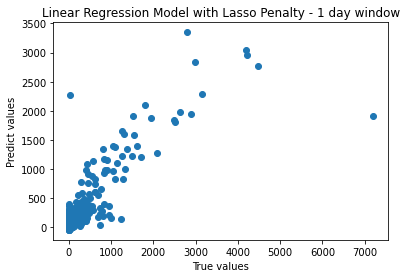

In [187]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Linear Regression Model with Lasso Penalty - 1 day window')
plt.scatter(y_test, y_predict_lr1)
plt.savefig('./lr_1.png')

In [188]:
print(best_estm_lr1.coef_)

[-4.57837710e-02  1.87961699e-01  5.16875179e-02  5.81927080e-02
  8.70155563e-02  1.76375435e-01  1.39770664e-01  1.77060646e-01
  5.79042201e-02 -9.67235453e-02 -2.46235134e-01  7.92419826e-01
  4.15196373e-01 -2.11131559e-01 -5.89744032e-01  4.82958577e-01
 -9.37320759e-01  6.48056225e-01 -6.41325956e-01 -5.35243580e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  6.35723477e+00 -1.89853330e+01 -1.37708960e-01  0.00000000e+00
 -2.61325296e+00  9.17906151e+00  5.58157965e+00 -4.87857325e-01
  0.00000000e+00  2.17180930e+00 -4.46900223e+00  2.40924756e+00
 -7.92424717e-01  1.20789511e+00 -2.77852811e-01 -0.00000000e+00
 -2.84833418e-01 -4.58009824e+00  4.28411112e+00 -5.99030722e-01
 -7.75385286e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.35114

In [189]:
print(X.columns)

Index(['Daily increase_1d', 'Daily increase_2d', 'Daily increase_3d',
       'Daily increase_4d', 'Daily increase_5d', 'Daily increase_6d',
       'Daily increase_7d', 'Daily increase_8d', 'Daily increase_9d',
       'Daily increase_10d',
       ...
       'Social distancing index_1d_5th_NEARBY',
       'COVID exposure/1000 people_1d_1st_NEARBY',
       'COVID exposure/1000 people_1d_2nd_NEARBY',
       'COVID exposure/1000 people_1d_3rd_NEARBY',
       'COVID exposure/1000 people_1d_4th_NEARBY',
       'COVID exposure/1000 people_1d_5th_NEARBY', 'NUM_LICENSED_BEDS',
       'NUM_STAFFED_BEDS', 'NUM_ICU_BEDS', 'AVG_VENTILATOR_USAGE'],
      dtype='object', length=110)


In [192]:
# from scipy import stats

# def generate_OLS(model, X_test, y_predict, y_test):
#     X_test = X_test.to_numpy()
        
#     params = np.append(model.intercept_,model.coef_)
#     newX = pd.DataFrame({"Constant":np.ones(len(X_test))}).join(pd.DataFrame(X_test)).astype(float)

#     MSE = (sum((y_predict)**2))/(len(newX) - len(newX.columns))

#     var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
#     sd_b = np.sqrt(var_b)
#     ts_b = params/ sd_b

#     print(len(newX[0]))
#     p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

#     sd_b = np.round(sd_b,3)
#     ts_b = np.round(ts_b,3)
#     p_values = np.round(p_values,3)
#     params = np.round(params,4)

#     myDF3 = pd.DataFrame()
#     myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["p values"] = [params,sd_b,ts_b,p_values]
#     print(myDF3)

In [193]:
#generate_OLS(best_estm_lr1, X_test, y_predict_lr1, y_test)

In [194]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(best_estm_lr1)
selector.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39089628.06492801, tolerance: 39646.61413863976
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.3))

In [195]:
selector.estimator_.coef_

array([ 0.00000000e+00,  1.98549044e-01,  3.69712945e-02, -7.57391990e-03,
        8.14045645e-02,  1.75179740e-01,  1.56150821e-01,  1.32809361e-01,
        8.21289580e-02, -6.19565345e-02, -1.44132350e-02,  7.65303112e-01,
        3.12413080e-01, -1.26246359e-01, -5.46631121e-01,  4.68013488e-01,
       -9.28625480e-01,  2.86394057e-01, -6.66279506e-01, -4.31880484e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -4.45293289e+00,
        1.93357723e+00, -1.49562012e+01, -1.04513232e-01,  0.00000000e+00,
       -2.21180449e+00,  9.68465549e+00,  1.23382434e+00, -0.00000000e+00,
        0.00000000e+00,  6.22165994e+00, -3.99170775e+00,  0.00000000e+00,
       -3.49308423e-01,  1.19529287e+00, -9.49170893e-01, -9.60203650e-02,
       -2.83115811e-01, -2.99634789e+00,  3.27142625e+00, -1.19409671e+00,
       -4.00290444e-01,  7.17198448e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [196]:
selector.get_support()

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True])

In [201]:
select = selector.get_support()
features = list(X_train.columns)
insig_index = [i for i in range(len(select)) if select[i] == False]
print([features[i] for i in insig_index])

['Daily increase_1d', 'Trips/person_1d', 'Trips/person_2d', 'Trips/person_3d', 'Trips/person_4d', 'Trips/person_5d', 'Trips/person_6d', 'Trips/person_7d', 'COVID exposure/1000 people_2d', 'COVID exposure/1000 people_6d', 'COVID exposure/1000 people_7d', 'COVID exposure/1000 people_10d', 'COVID death rate_1d', 'COVID death rate_2d', 'COVID death rate_3d', 'COVID death rate_4d', 'COVID death rate_5d', 'COVID death rate_6d', 'COVID death rate_7d', 'COVID death rate_8d', 'COVID death rate_9d', 'COVID death rate_10d', 'Active cases/1000 people_1d', 'Active cases/1000 people_3d', 'Active cases/1000 people_5d', 'Active cases/1000 people_6d', 'Active cases/1000 people_7d', 'Active cases/1000 people_8d', 'Active cases/1000 people_9d', 'Active cases/1000 people_10d', 'Hospital beds/1000 people_1d', 'COVID exposure/1000 people_1d_2nd_NEARBY', 'COVID exposure/1000 people_1d_3rd_NEARBY', 'COVID exposure/1000 people_1d_4th_NEARBY', 'COVID exposure/1000 people_1d_5th_NEARBY']


## Fit non-linear model with nested cross validation

In [202]:
parameter = {'max_depth': [20, 30, 40]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, parameter, scoring = 'neg_mean_squared_error')
cv_rf = cross_validate(clf_rf, X_train, y_train, cv = 5, return_estimator = True)

In [203]:
print('CV test score: ', cv_rf['test_score'])
print('mean CV test score', np.mean(cv_rf['test_score']))
index = np.argmax(cv_rf['test_score'])
best_estm_rf1 = cv_rf['estimator'][index].best_estimator_
best_estm_rf1

CV test score:  [-14428.36629354 -31216.92190119 -14166.08237024 -11913.6381241
 -27204.52918338]
mean CV test score -19785.907574491946


RandomForestRegressor(max_depth=40)

In [204]:
r2_rf1 = best_estm_rf1.score(X_test, y_test)
y_predict_rf1 = best_estm_rf1.predict(X_test)
mse_rf1 = mean_squared_error(y_test, y_predict_rf1)
print('R sqaure: ', r2_rf1)
print('rooted MSE: ', np.sqrt(mse_rf1))

R sqaure:  0.69505949079
rooted MSE:  233.83822710680616


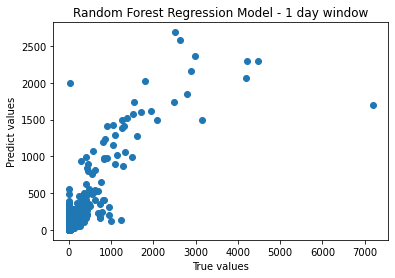

In [205]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Random Forest Regression Model - 1 day window')
plt.scatter(y_test, y_predict_rf1)
plt.savefig('./rf_1.png')

## Benchmark model check

### Benchmark 1: naive average daily increase model

In [206]:
X_test

,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,Daily increase_7d,Daily increase_8d,Daily increase_9d,Daily increase_10d,...,Social distancing index_1d_5th_NEARBY,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
5884,15,11,22,0,3,0,9,23,0,6,...,26.0,9.17,9.17,9.17,9.17,9.17,221.0,149.0,24,12.0
806,31,0,0,0,24,24,34,42,0,0,...,22.0,18.48,18.48,18.48,18.48,18.48,190.0,189.0,28,6.0
5073,50,22,23,44,10,21,28,0,53,0,...,30.0,21.60,21.60,21.60,21.60,21.60,30.0,30.0,2,0.0
5652,0,0,0,300,50,0,106,488,0,111,...,32.0,22.13,22.13,22.13,22.13,22.13,1379.0,1388.0,162,35.0
2661,10,5,0,0,0,35,0,1,0,5,...,30.0,21.74,21.74,21.74,21.74,21.74,137.0,129.0,10,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3318,218,85,96,142,0,244,175,0,114,190,...,23.0,5.27,5.27,5.27,5.27,5.27,6618.0,6345.0,698,175.0
4611,0,2,28,0,14,0,26,27,0,24,...,27.0,9.61,9.61,9.61,9.61,9.61,1519.0,1017.0,104,17.0
3369,1259,0,409,559,958,558,0,508,461,560,...,54.0,12.52,12.52,12.52,12.52,12.52,6618.0,6345.0,698,175.0
731,0,0,0,3,0,0,2,2,0,4,...,59.0,5.13,5.13,5.13,5.13,5.13,190.0,189.0,28,6.0


R square:  0.6770641627682312
rooted MSE:  240.63903119264202


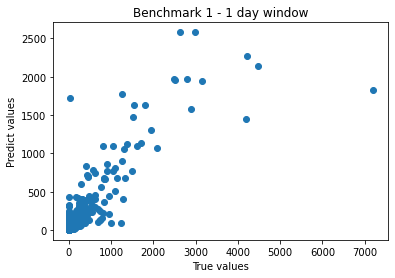

In [207]:
X_test_daily = X_test.iloc[:, 2:12]
#X_test_diff = X_test_daily.diff(axis = 1).abs()
y_predict_b11 = np.mean(X_test_daily, axis = 1)
r2_b11 = r2_score(y_test, y_predict_b11)
mse_b11 = mean_squared_error(y_test, y_predict_b11)
print('R square: ', r2_b11)
print('rooted MSE: ', np.sqrt(mse_b11))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 1 - 1 day window')
plt.scatter(y_test, y_predict_b11)
plt.savefig('./b1_1.png')


### Benchmark 2: naive time series model

CV test score:  [0.76255373 0.72101915 0.84039464 0.80485163 0.71220751]
mean CV test score 0.7682053322871059
R sqaure:  0.7392038467007395
rooted MSE:  216.25120680115882


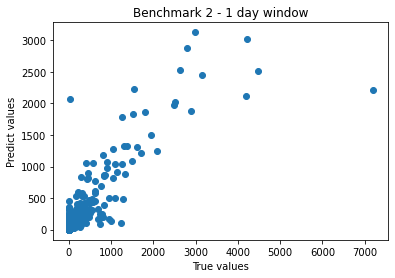

In [208]:
X_train_b2 = X_train.iloc[:, 2:12]
X_test_b2 = X_test.iloc[:, 2:12]

lr_b21 = LinearRegression()
cv_b21 = cross_validate(lr_b21, X_train_b2, y_train, cv = 5, return_estimator = True)
print('CV test score: ', cv_b21['test_score'])
print('mean CV test score', np.mean(cv_b21['test_score']))

index = np.argmax(cv_b21['test_score'])
best_estm_b21 = cv_b21['estimator'][index]
r2_b21= best_estm_b21.score(X_test_b2, y_test)
y_predict_b21 = best_estm_b21.predict(X_test_b2)
mse_b21 = mean_squared_error(y_test, y_predict_b21)
print('R sqaure: ', r2_b21)
print('rooted MSE: ', np.sqrt(mse_b21))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 2 - 1 day window')
plt.scatter(y_test, y_predict_b21)
plt.savefig('./b2_1.png')


In [209]:
print(best_estm_b21.coef_)

[ 0.03336727  0.0679048   0.12654475  0.15431864  0.1958615   0.19499518
  0.14049261  0.017      -0.47805109  0.65948045]


# Test models on 10 days period, 30 days period and 60 days period

# 10 days period

In [210]:
df_10d = get_after(df_basic.copy(), 'Daily increase', 'Daily increase_10d_after', 9)
df_10d = df_10d.drop(columns = ['Daily increase'])
df_10d.dropna(inplace = True)
df_10d.head()

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,Daily increase_7d,...,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE,Daily increase_10d_after
0,"Alameda,California",03/31/2020,"Alameda,California,03/31/2020",13,50,0,42,43,0,17,...,0.56,0.56,0.56,0.56,0.56,3464.0,3570.0,331,74.0,0
1,"Alameda,California",04/01/2020,"Alameda,California,04/01/2020",30,13,50,0,42,43,0,...,0.63,0.63,0.63,0.63,0.63,3464.0,3570.0,331,74.0,92
2,"Alameda,California",04/02/2020,"Alameda,California,04/02/2020",0,30,13,50,0,42,43,...,0.67,0.67,0.67,0.67,0.67,3464.0,3570.0,331,74.0,40
3,"Alameda,California",04/03/2020,"Alameda,California,04/03/2020",46,0,30,13,50,0,42,...,0.72,0.72,0.72,0.72,0.72,3464.0,3570.0,331,74.0,39
4,"Alameda,California",04/04/2020,"Alameda,California,04/04/2020",84,46,0,30,13,50,0,...,0.76,0.76,0.76,0.76,0.76,3464.0,3570.0,331,74.0,43


In [211]:
df_10d.shape

(5523, 114)

In [212]:
X = df_10d.iloc[:, 3:-1]
y = df_10d.iloc[:, -1]

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Fit linear model with lasso penalty and nested cross validation

In [214]:
parameter = {'alpha': [0.1, 0.2, 0.3]}
lr_lasso = linear_model.Lasso()
#clf_lr = GridSearchCV(lr_lasso, parameter, scoring = ('r2', 'neg_root_mean_squared_error'))
clf_lr = GridSearchCV(lr_lasso, parameter, scoring = 'neg_mean_squared_error')
cv_lr = cross_validate(clf_lr, X_train, y_train, cv = 5, return_estimator = True)

# cv_lr_score = cross_val_score(clf_lr, X_train, y_train)
# cv_lr_score

#clf_lr.fit(X_train, y_train)

#cv_lr['test_score']
#cv_result = cross_validate(reg, X_train, y_train, cv = 5, return_estimator = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49827557.67361698, tolerance: 34741.795292960735
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53271564.32643795, tolerance: 35577.82037743193
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33277493.56628171, tolerance: 28359.156139511877
  model = cd_fast.enet_coordinate_descent(
/L

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40508241.89421428, tolerance: 31825.454888967462
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49856643.31772448, tolerance: 34608.26962334632
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48024379.92657056, tolerance: 34884.80795026532
  model = cd_fast.enet_coordinate_descent(
/Li

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29148158.72862205, tolerance: 26909.025780304077
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45174376.19208366, tolerance: 33600.564913578484
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52995169.78552599, tolerance: 36384.18895173266
  model = cd_fast.enet_coordinate_descent(
/L

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23894827.10266728, tolerance: 23323.542811315412
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41459595.74985115, tolerance: 31679.32816704384
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48206607.04631203, tolerance: 37067.438077114544
  model = cd_fast.enet_coordinate_descent(


In [215]:
print('CV test score: ', cv_lr['test_score'])
print('mean CV test score', np.mean(cv_lr['test_score']))
index = np.argmax(cv_lr['test_score'])
best_estm_lr10 = cv_lr['estimator'][index].best_estimator_
best_estm_lr10

CV test score:  [-16349.85584099 -28871.51056878 -65779.58269732 -19136.32723819
 -43074.91717806]
mean CV test score -34642.43870466827


Lasso(alpha=0.2)

In [216]:
r2_lr10 = best_estm_lr10.score(X_test, y_test)
y_predict_lr10 = best_estm_lr10.predict(X_test)
mse_lr10 = mean_squared_error(y_test, y_predict_lr10)
print('R sqaure: ', r2_lr10)
print('rooted MSE: ', np.sqrt(mse_lr10))

R sqaure:  0.7335701337815
rooted MSE:  166.9961896248178


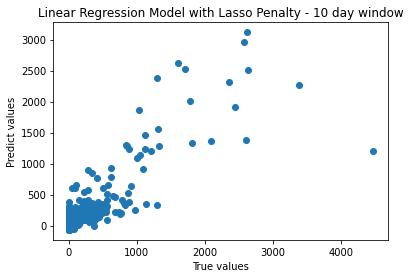

In [217]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Linear Regression Model with Lasso Penalty - 10 day window')
plt.scatter(y_test, y_predict_lr10)
plt.savefig('./lr_10.png')

In [218]:
print(best_estm_lr10.coef_)
print(X_test.columns.values)

[ 2.82483557e-02 -1.01919280e-01  1.07653171e-01  1.04280937e-01
  2.01370613e-01  2.45085302e-01  1.03389952e-01  6.54248904e-02
 -8.20318736e-03 -8.07176150e-02  8.31779891e-01 -6.15605576e-02
 -6.25662313e-03  1.69639253e-01 -1.14174929e+00 -1.72416480e-01
 -6.36624105e-01  2.80198114e-01 -9.04008821e-01 -1.66791244e-01
 -0.00000000e+00 -7.87042332e+00 -2.14473265e+01  1.52707283e+01
 -2.22837359e+01  1.03626252e+01 -3.50474914e+01  2.46727777e+01
 -5.42406746e+00  2.87528386e+01 -0.00000000e+00  3.09577699e+01
 -3.00873698e+00  1.69675863e+00 -1.50202320e+00  1.17725221e+01
 -0.00000000e+00  2.89105348e+00  7.01342320e+00 -4.71280061e+00
 -3.81907105e+00 -3.77524618e-01 -2.01292857e-01  8.11347485e-01
 -2.98101859e+00 -1.78932737e+00 -1.35957496e+00  5.38657949e+00
 -2.00657343e+00  7.33101809e-01  0.00000000e+00  0.00000000e+00
  7.72904418e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.66136338e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.26956132e+01  5.52537

In [219]:
selector = SelectFromModel(best_estm_lr10)
selector.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65778452.987334825, tolerance: 48999.90710448172
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.2))

In [220]:
selector.estimator_.coef_

array([ 5.68617393e-02, -7.91706118e-02,  1.31317102e-01,  1.87625739e-01,
        1.81277456e-01,  1.85310589e-01,  6.64789577e-02,  4.45678600e-02,
       -3.10002682e-02, -1.12233210e-01,  1.06904970e+00,  1.15693044e-01,
       -1.71743133e-01,  1.69207908e-01, -8.26227872e-01, -2.10610813e-01,
       -1.14066829e-01,  6.42155298e-03, -1.18913783e+00, -4.98022553e-01,
       -0.00000000e+00, -0.00000000e+00, -2.67743978e+01,  1.85562950e+01,
       -1.13049849e+01,  1.80553784e+00, -3.37974513e+00,  1.34681915e+01,
       -1.05587067e+01,  1.07984790e+01, -0.00000000e+00,  2.23084531e+01,
       -3.70923865e+00,  3.57094708e+00, -9.96278395e-01,  8.51477066e+00,
       -1.41960602e+00,  5.34280647e+00,  3.80731967e+00, -2.23127835e+00,
       -3.29316706e+00,  1.80004561e+00, -6.22548194e-01,  2.27319920e-01,
       -3.63267248e+00, -0.00000000e+00, -5.80697650e-01,  2.75816623e+00,
       -0.00000000e+00,  5.56567710e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [221]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True])

## Fit non-linear model with nested cross validation

In [222]:
parameter = {'max_depth': [20, 30, 40]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, parameter, scoring = 'neg_mean_squared_error')
cv_rf = cross_validate(clf_rf, X_train, y_train, cv = 5, return_estimator = True)

In [223]:
print('CV test score: ', cv_rf['test_score'])
print('mean CV test score', np.mean(cv_rf['test_score']))
index = np.argmax(cv_rf['test_score'])
best_estm_rf10 = cv_rf['estimator'][index].best_estimator_
best_estm_rf10

CV test score:  [-12452.20770392 -35174.59277552 -62680.14272724 -21204.6668611
 -38693.0842579 ]
mean CV test score -34040.93886513625


RandomForestRegressor(max_depth=20)

In [224]:
r2_rf10 = best_estm_rf10.score(X_test, y_test)
y_predict_rf10 = best_estm_rf10.predict(X_test)
mse_rf10 = mean_squared_error(y_test, y_predict_rf10)
print('R sqaure: ', r2_rf10)
print('rooted MSE: ', np.sqrt(mse_rf10))

R sqaure:  0.8077250811698675
rooted MSE:  141.86538039114822


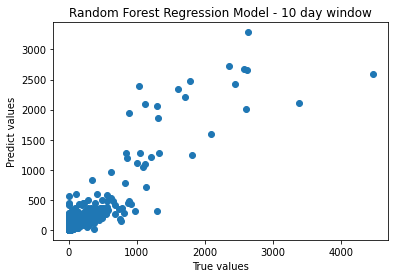

In [225]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Random Forest Regression Model - 10 day window')
plt.scatter(y_test, y_predict_rf10)
plt.savefig('./rf_10.png')

## Benchmark model check

### Benchmark 1: naive average daily increase model

R square:  0.7274915887152311
rooted MSE:  168.8904389568596


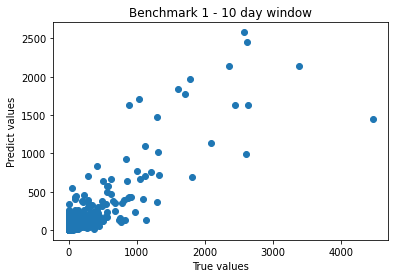

In [226]:
X_test_daily = X_test.iloc[:, 2:12]
y_predict_b110 = np.mean(X_test_daily, axis = 1)
r2_b110 = r2_score(y_test, y_predict_b110)
mse_b110 = mean_squared_error(y_test, y_predict_b110)
print('R square: ', r2_b110)
print('rooted MSE: ', np.sqrt(mse_b110))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 1 - 10 day window')
plt.scatter(y_test, y_predict_b110)
plt.savefig('./b1_10.png')


### Benchmark 2: naive time series model

CV test score:  [0.76728124 0.69053866 0.58588307 0.72301637 0.66525117]
mean CV test score 0.6863941018830731
R sqaure:  0.7264398698479345
rooted MSE:  169.21603296058646


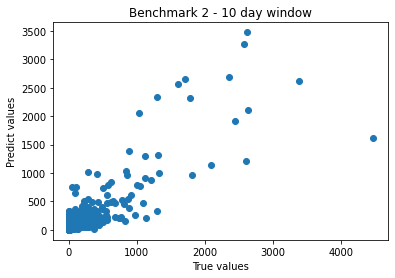

In [227]:
X_train_b2 = X_train.iloc[:, 2:12]
X_test_b2 = X_test.iloc[:, 2:12]

lr_b210 = LinearRegression()
cv_b210 = cross_validate(lr_b210, X_train_b2, y_train, cv = 5, return_estimator = True)
print('CV test score: ', cv_b210['test_score'])
print('mean CV test score', np.mean(cv_b210['test_score']))

index = np.argmax(cv_b210['test_score'])
best_estm_b210 = cv_b210['estimator'][index]
r2_b210= best_estm_b210.score(X_test_b2, y_test)
y_predict_b210 = best_estm_b210.predict(X_test_b2)
mse_b210 = mean_squared_error(y_test, y_predict_b210)
print('R sqaure: ', r2_b210)
print('rooted MSE: ', np.sqrt(mse_b210))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 2 - 10 day window')
plt.scatter(y_test, y_predict_b210)
plt.savefig('./b2_10.png')


## 30 days period

In [228]:
df_30d = get_after(df_basic.copy(), 'Daily increase', 'Daily increase_30d_after', 29)
df_30d = df_30d.drop(columns = ['Daily increase'])
df_30d.dropna(inplace = True)
df_30d.head()

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,Daily increase_7d,...,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE,Daily increase_30d_after
0,"Alameda,California",03/31/2020,"Alameda,California,03/31/2020",13,50,0,42,43,0,17,...,0.56,0.56,0.56,0.56,0.56,3464.0,3570.0,331,74.0,35
1,"Alameda,California",04/01/2020,"Alameda,California,04/01/2020",30,13,50,0,42,43,0,...,0.63,0.63,0.63,0.63,0.63,3464.0,3570.0,331,74.0,35
2,"Alameda,California",04/02/2020,"Alameda,California,04/02/2020",0,30,13,50,0,42,43,...,0.67,0.67,0.67,0.67,0.67,3464.0,3570.0,331,74.0,33
3,"Alameda,California",04/03/2020,"Alameda,California,04/03/2020",46,0,30,13,50,0,42,...,0.72,0.72,0.72,0.72,0.72,3464.0,3570.0,331,74.0,70
4,"Alameda,California",04/04/2020,"Alameda,California,04/04/2020",84,46,0,30,13,50,0,...,0.76,0.76,0.76,0.76,0.76,3464.0,3570.0,331,74.0,43


In [229]:
df_30d.shape

(4603, 114)

In [230]:
X = df_30d.iloc[:, 3:-1]
y = df_30d.iloc[:, -1]

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fit linear model with lasso penalty and nested cross validation

In [232]:
parameter = {'alpha': [0.1, 0.2, 0.3]}
lr_lasso = linear_model.Lasso()
clf_lr = GridSearchCV(lr_lasso, parameter, scoring = 'neg_mean_squared_error')
cv_lr = cross_validate(clf_lr, X_train, y_train, cv = 5, return_estimator = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53993347.84639545, tolerance: 34330.009633404086
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49067701.56700309, tolerance: 34319.09110814941
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48967601.31161404, tolerance: 32221.14195802208
  model = cd_fast.enet_coordinate_descent(
/Li

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56239644.39562561, tolerance: 36242.35598077248
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51704745.85583969, tolerance: 32397.97114443973
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54681943.531085126, tolerance: 32209.409779456713
  model = cd_fast.enet_coordinate_descent(
/L

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32156773.47935324, tolerance: 24515.77341094612
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30947445.258338057, tolerance: 27345.357917826826
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29500080.698722225, tolerance: 22302.732437675022
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36209222.83382486, tolerance: 26585.622729486644
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66308839.62882872, tolerance: 40227.383517481314
  model = cd_fast.enet_coordinate_descent(


In [233]:
print('CV test score: ', cv_lr['test_score'])
print('mean CV test score', np.mean(cv_lr['test_score']))
index = np.argmax(cv_lr['test_score'])
best_estm_lr30 = cv_lr['estimator'][index].best_estimator_
best_estm_lr30

CV test score:  [ -43111.57149137  -23489.06985261  -40887.41844482 -102479.06664522
  -22503.06209446]
mean CV test score -46494.03770569675


Lasso(alpha=0.3)

In [234]:
r2_lr30 = best_estm_lr30.score(X_test, y_test)
y_predict_lr30 = best_estm_lr30.predict(X_test)
mse_lr30 = mean_squared_error(y_test, y_predict_lr30)
print('R sqaure: ', r2_lr30)
print('rooted MSE: ', np.sqrt(mse_lr30))

R sqaure:  0.7752592301896708
rooted MSE:  161.48692935635088


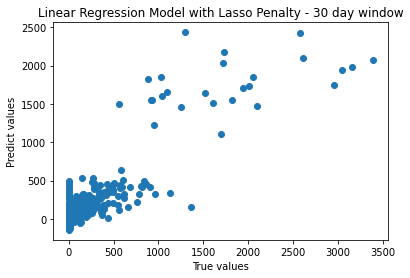

In [235]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Linear Regression Model with Lasso Penalty - 30 day window')
plt.scatter(y_test, y_predict_lr30)
plt.savefig('./lr_30.png')


In [236]:
print(best_estm_lr30.coef_)
print(X_test.columns.values)

[ 1.22618834e-01  1.68130064e-01  7.89569967e-02  3.51961305e-02
 -4.21461860e-02 -1.31315282e-01 -2.19162796e-02 -1.12134797e-01
  2.13705127e-01 -1.63976136e-01  6.08820058e-01 -1.00744574e+00
 -4.16148428e-01 -1.11385638e+00 -1.43838026e+00 -2.25537793e-01
 -9.09121216e-01  1.13003945e+00  9.73492327e-01 -6.59781835e-02
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.10143979e+01
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  4.98439481e+00 -2.56423236e+01
  1.51367894e+01 -1.92411214e+01  8.80870889e+00 -0.00000000e+00
 -4.37413052e-02 -6.22316312e+00  0.00000000e+00 -6.53600035e+00
 -4.62899635e+00  4.37194883e+00 -4.44187144e+00 -5.40358616e-02
  7.30099066e+00 -3.34248945e+00 -1.43506993e+00 -2.89369157e+00
  3.79117858e+00  3.02066011e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -3.97956606e+00 -0.00000000e+00
 -2.62719806e+01 -6.45160

In [237]:
selector = SelectFromModel(best_estm_lr30)
selector.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74289125.50234137, tolerance: 47732.20800206408
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.3))

In [238]:
selector.estimator_.coef_

array([ 1.34028004e-01,  1.76293707e-01,  9.11867578e-02,  2.30979334e-02,
       -3.64466732e-02, -1.28593671e-01, -2.24650767e-02, -1.03799359e-01,
        2.06024710e-01, -1.38929641e-01,  7.11170866e-01, -6.68262608e-01,
       -4.94949400e-01, -1.17525727e+00, -1.31009603e+00, -3.19238072e-01,
       -8.29756732e-01,  1.13771410e+00,  7.40518974e-01, -2.25606891e-01,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -2.03849837e+01,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -4.54682808e+00,  4.67652807e+00, -1.67883362e+01,
        6.56255794e+00, -1.82864351e+01,  1.38128193e+01,  1.19755752e+00,
       -0.00000000e+00, -9.00394417e-01, -0.00000000e+00, -1.45098905e+01,
       -2.44302859e+00,  2.14548440e+00, -2.40417642e+00, -2.24277493e+00,
        5.34206882e+00, -2.83844128e+00, -2.03528485e+00, -2.26573734e+00,
        4.22082216e+00,  4.10175193e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [239]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True, False, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True])

### Fit non-linear model with nested cross validation

In [240]:
parameter = {'max_depth': [20, 30, 40]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, parameter, scoring = 'neg_mean_squared_error')
cv_rf = cross_validate(clf_rf, X_train, y_train, cv = 5, return_estimator = True)

In [241]:
print('CV test score: ', cv_rf['test_score'])
print('mean CV test score', np.mean(cv_rf['test_score']))
index = np.argmax(cv_rf['test_score'])
best_estm_rf30 = cv_rf['estimator'][index].best_estimator_
best_estm_rf30

CV test score:  [-27037.48634128 -19860.3520038  -38825.64830274 -76353.20279154
 -18487.90550246]
mean CV test score -36112.91898836453


RandomForestRegressor(max_depth=20)

In [242]:
r2_rf30 = best_estm_rf30.score(X_test, y_test)
y_predict_rf30 = best_estm_rf30.predict(X_test)
mse_rf30 = mean_squared_error(y_test, y_predict_rf30)
print('R sqaure: ', r2_rf30)
print('rooted MSE: ', np.sqrt(mse_rf30))

R sqaure:  0.8575441715803593
rooted MSE:  128.5690857978444


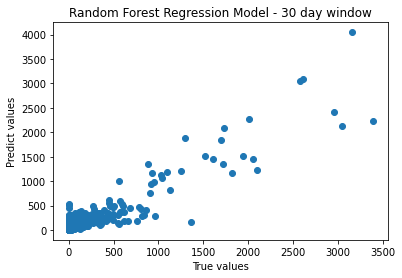

In [243]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Random Forest Regression Model - 30 day window')
plt.scatter(y_test, y_predict_rf30)
plt.savefig('./rf_30.png')


### Benchmark 1: naive average daily increase model

R square:  0.5635991868381441
rooted MSE:  225.02937817615117


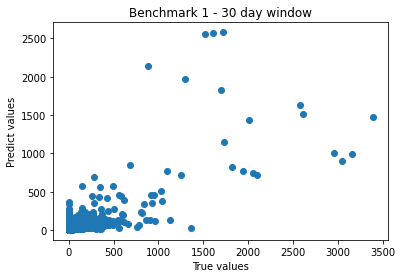

In [244]:
X_test_daily = X_test.iloc[:, 2:12]
y_predict_b130 = np.mean(X_test_daily, axis = 1)
r2_b130 = r2_score(y_test, y_predict_b130)
mse_b130 = mean_squared_error(y_test, y_predict_b130)
print('R square: ', r2_b130)
print('rooted MSE: ', np.sqrt(mse_b130))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 1 - 30 day window')
plt.scatter(y_test, y_predict_b130)
plt.savefig('./b1_30.png')


### Benchmark 2: naive time series model

CV test score:  [0.43601873 0.48136426 0.40477049 0.40680388 0.629137  ]
mean CV test score 0.4716188729675105
R sqaure:  0.6052261256724301
rooted MSE:  214.02802623551452


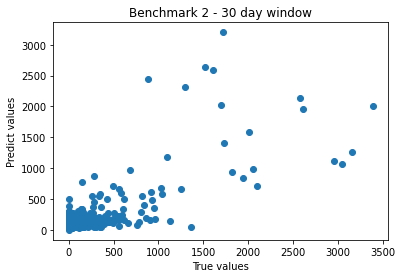

In [245]:
X_train_b2 = X_train.iloc[:, 2:12]
X_test_b2 = X_test.iloc[:, 2:12]

lr_b230 = LinearRegression()
cv_b230 = cross_validate(lr_b230, X_train_b2, y_train, cv = 5, return_estimator = True)
print('CV test score: ', cv_b230['test_score'])
print('mean CV test score', np.mean(cv_b230['test_score']))

index = np.argmax(cv_b230['test_score'])
best_estm_b230 = cv_b230['estimator'][index]
r2_b230= best_estm_b230.score(X_test_b2, y_test)
y_predict_b230 = best_estm_b230.predict(X_test_b2)
mse_b230 = mean_squared_error(y_test, y_predict_b230)
print('R sqaure: ', r2_b230)
print('rooted MSE: ', np.sqrt(mse_b230))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 2 - 30 day window')
plt.scatter(y_test, y_predict_b230)
plt.savefig('./b2_30.png')


## 60 days period

In [246]:
df_60d = get_after(df_basic.copy(), 'Daily increase', 'Daily increase_30d_after', 59)
df_60d = df_60d.drop(columns = ['Daily increase'])
df_60d.dropna(inplace = True)
df_60d.head()

,COUNTY,DATE,COUNTY_AND_DATE,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,Daily increase_7d,...,COVID exposure/1000 people_1d_1st_NEARBY,COVID exposure/1000 people_1d_2nd_NEARBY,COVID exposure/1000 people_1d_3rd_NEARBY,COVID exposure/1000 people_1d_4th_NEARBY,COVID exposure/1000 people_1d_5th_NEARBY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE,Daily increase_30d_after
0,"Alameda,California",03/31/2020,"Alameda,California,03/31/2020",13,50,0,42,43,0,17,...,0.56,0.56,0.56,0.56,0.56,3464.0,3570.0,331,74.0,98
1,"Alameda,California",04/01/2020,"Alameda,California,04/01/2020",30,13,50,0,42,43,0,...,0.63,0.63,0.63,0.63,0.63,3464.0,3570.0,331,74.0,94
2,"Alameda,California",04/02/2020,"Alameda,California,04/02/2020",0,30,13,50,0,42,43,...,0.67,0.67,0.67,0.67,0.67,3464.0,3570.0,331,74.0,101
3,"Alameda,California",04/03/2020,"Alameda,California,04/03/2020",46,0,30,13,50,0,42,...,0.72,0.72,0.72,0.72,0.72,3464.0,3570.0,331,74.0,80
4,"Alameda,California",04/04/2020,"Alameda,California,04/04/2020",84,46,0,30,13,50,0,...,0.76,0.76,0.76,0.76,0.76,3464.0,3570.0,331,74.0,45


In [247]:
df_60d.shape

(3223, 114)

In [248]:
X = df_60d.iloc[:, 3:-1]
y = df_60d.iloc[:, -1]

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fit linear model with lasso penalty and nested cross validation

In [250]:
parameter = {'alpha': [0.1, 0.2, 0.3]}
lr_lasso = linear_model.Lasso()
clf_lr = GridSearchCV(lr_lasso, parameter, scoring = 'neg_mean_squared_error')
cv_lr = cross_validate(clf_lr, X_train, y_train, cv = 5, return_estimator = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25787295.445905507, tolerance: 25136.666855912685
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29108146.72385191, tolerance: 27355.429897392358
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22879965.238547873, tolerance: 22470.936798121213
  model = cd_fast.enet_coordinate_descent(

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27956686.382332943, tolerance: 25015.115350030326
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42396973.618985206, tolerance: 33230.51013826563
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39075175.371361576, tolerance: 28240.21271327273
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42294399.71780677, tolerance: 27867.04270466384
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26881337.373504933, tolerance: 22963.164200000003
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41042768.357022814, tolerance: 30903.555316121234
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44739813.652121946, tolerance: 32258.878581950325
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42791962.0044114, tolerance: 29219.070635978194
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52270855.766323976, tolerance: 37322.70377227338
  model = cd_fast.enet_coordinate_descent(


In [251]:
print('CV test score: ', cv_lr['test_score'])
print('mean CV test score', np.mean(cv_lr['test_score']))
index = np.argmax(cv_lr['test_score'])
best_estm_lr60 = cv_lr['estimator'][index].best_estimator_
best_estm_lr60

CV test score:  [-110437.67143158  -40458.00297667  -42582.89797756  -47920.81348996
  -39925.7026209 ]
mean CV test score -56265.01769933353


Lasso(alpha=0.1)

In [252]:
r2_lr60 = best_estm_lr60.score(X_test, y_test)
y_predict_lr60 = best_estm_lr60.predict(X_test)
mse_lr60 = mean_squared_error(y_test, y_predict_lr60)
print('R sqaure: ', r2_lr60)
print('rooted MSE: ', np.sqrt(mse_lr60))

R sqaure:  0.6532710304656089
rooted MSE:  207.76888412834654


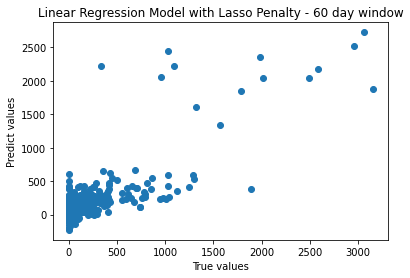

In [253]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Linear Regression Model with Lasso Penalty - 60 day window')
plt.scatter(y_test, y_predict_lr60)
plt.savefig('./lr_60.png')


In [254]:
print(best_estm_lr60.coef_)
print(X_test.columns.values)

[ 3.74720794e-03  3.42009475e-01 -1.10695480e-01 -2.02463126e-01
 -5.52918661e-03 -3.03215991e-01 -4.03409207e-01  4.37168676e-01
 -3.22647931e-01  6.38780072e-01 -7.77199194e-01 -1.49481489e+00
 -4.29771704e-01 -2.15567123e+00 -8.30036205e-01  1.76075551e+00
  1.51549088e+00  1.49671612e-01  2.06536961e+00 -1.53977857e+00
 -0.00000000e+00 -2.55654799e+01 -1.53518330e+01 -4.34294846e+01
 -0.00000000e+00  3.65251818e+01  3.81697675e+01  0.00000000e+00
  4.36124274e+01  7.08544081e+00  1.70442327e+00  5.35934085e+01
 -5.71035060e+01  2.63871130e+01  3.52062683e+01  4.06874287e+01
 -3.72046101e+01  0.00000000e+00 -6.47339057e+01  3.00088603e+01
  3.70911181e+00 -1.89596405e+01  1.62576600e+01  6.21796357e+00
  1.13708919e+00  8.09585098e+00 -1.09269854e+01  2.03218145e+00
 -1.56662893e+01  4.52569218e+00 -5.05542164e+01 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.15284506e+02  0.00000000e+00
 -2.96647077e+01 -8.77428997e+01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -2.04150

In [255]:
selector = SelectFromModel(best_estm_lr60)
selector.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61137374.96832649, tolerance: 45356.311340108616
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.1))

In [256]:
selector.estimator_.coef_

array([-6.86270787e-02,  2.46613446e-01, -1.19079195e-01, -7.12128127e-02,
       -8.57083972e-02, -2.71990963e-01, -1.81932737e-01,  2.45821149e-01,
       -2.54787185e-01,  5.04797295e-01, -1.49418720e+00, -8.52726246e-01,
       -1.28435986e+00, -1.50493186e+00, -5.42476696e-01,  1.43116590e+00,
        1.60061518e+00, -7.52961535e-03,  8.99129351e-01, -8.51636019e-01,
       -0.00000000e+00, -1.80254606e+01, -1.00670133e+01, -2.70324025e+01,
       -0.00000000e+00,  2.87623798e+01,  5.38268190e+01, -0.00000000e+00,
        1.56069068e+01,  0.00000000e+00,  1.26553905e+00,  5.10659844e+01,
       -5.15817427e+01,  3.01956601e+01,  1.76678999e+01,  2.81731574e+01,
       -3.09370780e+01,  1.75616419e+01, -4.41149853e+01,  2.08517511e+01,
        1.53359013e+00, -1.00590459e+01,  9.18164236e+00,  7.45399578e+00,
       -3.53326431e+00,  4.24988636e+00, -9.02823248e+00,  9.58042447e+00,
       -1.52262957e+01,  4.72865514e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

In [257]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False, False,  True, False,  True, False,  True,  True,
        True, False, False, False, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True])

### Fit non-linear model with nested cross validation

In [258]:
parameter = {'max_depth': [20, 30, 40]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, parameter, scoring = 'neg_mean_squared_error')
cv_rf = cross_validate(clf_rf, X_train, y_train, cv = 5, return_estimator = True)

In [259]:
print('CV test score: ', cv_rf['test_score'])
print('mean CV test score', np.mean(cv_rf['test_score']))
index = np.argmax(cv_rf['test_score'])
best_estm_rf60 = cv_rf['estimator'][index].best_estimator_
best_estm_rf60

CV test score:  [-94675.85806795 -62899.27711202 -28372.74044611 -38297.4630066
 -20566.25690993]
mean CV test score -48962.3191085204


RandomForestRegressor(max_depth=20)

In [260]:
r2_rf60 = best_estm_rf60.score(X_test, y_test)
y_predict_rf60 = best_estm_rf60.predict(X_test)
mse_rf60 = mean_squared_error(y_test, y_predict_rf60)
print('R sqaure: ', r2_rf60)
print('rooted MSE: ', np.sqrt(mse_rf60))

R sqaure:  0.7379153254428483
rooted MSE:  180.6368103610501


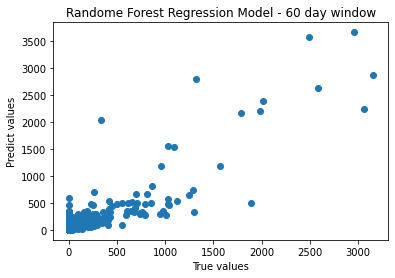

In [261]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Randome Forest Regression Model - 60 day window')
plt.scatter(y_test, y_predict_rf60)
plt.savefig('./rf_60.png')


### Benchmark 1: naive average daily increase model

In [262]:
max(y_test)

3155

R square:  0.323933396438156
rooted MSE:  290.12168051332526


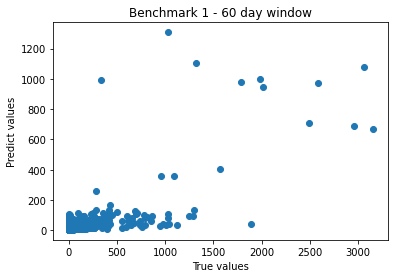

In [263]:
X_test_daily = X_test.iloc[:, 2:12]
y_predict_b160 = np.mean(X_test_daily, axis = 1)
r2_b160 = r2_score(y_test, y_predict_b160)
mse_b160 = mean_squared_error(y_test, y_predict_b160)
print('R square: ', r2_b160)
print('rooted MSE: ', np.sqrt(mse_b160))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 1 - 60 day window')
plt.scatter(y_test, y_predict_b160)
plt.savefig('./b1_60.png')


### Benchmark 2: naive time series model

CV test score:  [0.39288538 0.5413271  0.48475527 0.63386578 0.4956776 ]
mean CV test score 0.5097022257892917
R sqaure:  0.5497722875191549
rooted MSE:  236.75630557928216


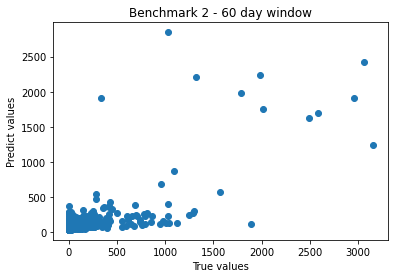

In [264]:
X_train_b2 = X_train.iloc[:, 2:12]
X_test_b2 = X_test.iloc[:, 2:12]

lr_b260 = LinearRegression()
cv_b260 = cross_validate(lr_b260, X_train_b2, y_train, cv = 5, return_estimator = True)
print('CV test score: ', cv_b260['test_score'])
print('mean CV test score', np.mean(cv_b260['test_score']))

index = np.argmax(cv_b260['test_score'])
best_estm_b260 = cv_b260['estimator'][index]
r2_b260= best_estm_b260.score(X_test_b2, y_test)
y_predict_b260 = best_estm_b260.predict(X_test_b2)
mse_b260 = mean_squared_error(y_test, y_predict_b260)
print('R sqaure: ', r2_b260)
print('rooted MSE: ', np.sqrt(mse_b260))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 2 - 60 day window')
plt.scatter(y_test, y_predict_b260)
plt.savefig('./b2_60.png')


# Save models

In [265]:
import joblib

In [266]:
joblib.dump(best_estm_lr1, './model/lr_1.sav')
joblib.dump(best_estm_lr10, './model/lr_10.sav')
joblib.dump(best_estm_lr30, './model/lr_30.sav')
joblib.dump(best_estm_lr60, './model/lr_60.sav')

['./model/lr_60.sav']

In [267]:
joblib.dump(best_estm_rf1, './model/rf_1.sav')
joblib.dump(best_estm_rf10, './model/rf_10.sav')
joblib.dump(best_estm_rf30, './model/rf_30.sav')
joblib.dump(best_estm_rf60, './model/rf_60.sav')

['./model/rf_60.sav']

In [268]:
# How to load model
# If needed, uncomment this cell
# loaded_model = joblib.load('./model/rf_1.sav')

# Temporal analysis

# Geographic analysis

In [ ]:
# Reload dataset
df_basic = pd.read_csv('./data/basic_data.csv', index_col = 0)
df_basic.head()

In [ ]:
# df_10d = get_after(df_basic.copy(), 'Daily increase', 'Daily increase_10d_after', 9)
# df_10d = df_10d.drop(columns = ['Daily increase'])
# df_10d.dropna(inplace = True)
# df_10d.head()

In [ ]:
df_fips = pd.read_csv('/Users/junyiguo/Documents/summer_project/social_mobility_data/fips-counties.csv', 
                      usecols = ['fips', 'county_name', 'state_name'])
df_fips.head()

In [ ]:
df_fips['fips'] = df_fips['fips'].apply(lambda x: '{:05}'.format(x))
df_fips['county_name'] = df_fips['county_name'].apply(lambda x: x.replace(str(' County'), ''))
df_fips['COUNTY'] = df_fips['county_name'] + str(',') + df_fips['state_name']
df_fips.head()

In [ ]:
df_fips.drop(columns = ['county_name', 'state_name'], inplace = True)
df_fips.head()

In [ ]:
# Check duplicate rows
seen = {}
dupes = []

for x in df_fips['fips']:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
dupes

In [ ]:
idx = df_fips[df_fips['fips'] == '11001'].index.values[0]
df_fips = df_fips.drop(index = idx)
df_fips.shape

In [ ]:
df_basic.head()

In [ ]:
X = df_basic.iloc[:, 4:]
y = df_basic.iloc[:, 3]

In [ ]:
y_predict = loaded_model.predict(X)

In [ ]:
df_predict = pd.DataFrame({'COUNTY': df_basic['COUNTY'], 'y': y, 'y_predict': y_predict})
df_predict.shape

In [ ]:
df_geo = pd.merge(df_fips, df_predict, how = 'right', on = 'COUNTY')
df_geo.dropna(inplace = True)
df_geo.shape

In [ ]:
df_geo.head()

In [ ]:
geo_group = df_geo.groupby(by = 'fips')
fips_key = list(geo_group.groups.keys())
mse_list = []
#df_geo_group.get_group('Autauga,Alabama')
for key in fips_key:
    df = geo_group.get_group(key)
    mse = mean_squared_error(df['y'], df['y_predict'])
    mse_list.append(np.sqrt(mse))
print(len(fips_key), len(mse_list))

In [ ]:
#import plotly.figure_factory as ff
#from plotly.tools import FigureFactory as ff
from plotly.figure_factory import create_choropleth

In [ ]:
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(0, 1000, len(colorscale) - 1))

fig = create_choropleth(
    fips = fips_key, values = mse_list,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='COVID19 Positive Test Prediction',
    legend_title='Rooted Mean Squared Error'
)

fig.layout.template = None
fig.show()

# Plot daily increase

In [ ]:
!conda install geopandas

In [ ]:
! pip3 install shapely==1.6.3

In [ ]:
! y

In [ ]:
!pip install plotly-geo

In [ ]:
min(mse_list)

In [ ]:
max(mse_list)

In [ ]:
mse_list

### Subset the data from California and Massachusetts to test the model

In [ ]:
df_MACA = df_mobility_COVID19_new[df_mobility_COVID19_new['COUNTY'].str.contains('Massachusetts|California')]
df_MACA.head()

In [ ]:
df_sub = df_MACA.iloc[:20]
df_sub

In [ ]:
period_date = 10
for period in range(1, period_date + 1):
    new_col_name = 'Daily increase_' + str(period) + 'd'
    df_MACA = get_previous(df_MACA.copy(), 'Daily increase', new_col_name, period)

df_MACA.iloc[:20]

In [ ]:
period_date = 10
for period in range(1, period_date + 1):
    new_col_name = 'Social distancing index_' + str(period) + 'd'
    df_MACA = get_previous(df_MACA.copy(), 'Social distancing index', new_col_name, period)

df_MACA.iloc[:20]

In [ ]:
all(df_MACA.groupby('COUNTY')['% people older than 60'].value_counts() == 118)

In [ ]:
all(df_MACA.groupby('COUNTY')['Population density'].value_counts() == 118)

In [ ]:
new_col_name = 'New case/100 people_1d'
df_MACA = get_previous(df_MACA.copy(), 'New cases/1000 people', new_col_name, 1)

In [ ]:
df_MACA.head()

In [ ]:
new_col_name = 'COVID death rate_1d'
df_MACA = get_previous(df_MACA.copy(), 'COVID death rate', new_col_name, 1)
df_MACA.head()

In [ ]:
df_MACA_include_previous = df_MACA.dropna()
df_MACA_include_previous.head()

In [ ]:
df_MACA_dropped = df_MACA_include_previous.drop(columns = ['Social distancing index', 'New cases/1000 people', 'COVID death rate'])
df_MACA_dropped.head()

In [ ]:
df_MACA_reset_index = df_MACA_dropped.reset_index()
nearby_avg_dailyinc = [get_NearbyAverage(df_MACA_reset_index, index, 'Daily increase_1d') 
              for index in df_MACA_reset_index.index]
df_MACA_dropped['nearby_avg_dailyinc_1d'] = nearby_avg_dailyinc
df_MACA_dropped.head()

In [ ]:
df_MACA_reset_index = df_MACA_dropped.reset_index()
nearby_avg_socialidx = [get_NearbyAverage(df_MACA_reset_index, index, 'Social distancing index_1d') 
              for index in df_MACA_reset_index.index]
df_MACA_dropped['nearby_avg_socialidx'] = nearby_avg_socialidx
df_MACA_dropped.head()

In [ ]:
df_MACA_final = df_MACA_dropped.dropna()
print(df_MACA_final.shape)
df_MACA_final.head()